In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

In [21]:
# root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-26/05-00-12"
# root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-26/15-41-49"

# M=71, test_size=0.3
root = '/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-26/19-57-45'

# M = 71, test_size=0.5
# root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-26/20-12-20"

# M=71, test_size=0.7
# root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00"

# M=47, test_size=0.5
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/04-38-59"

# M=47, test_size=0.7
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/04-44-26"

# M=47, test_size=0.7, hidden dim=256, grokking happens at a very slow pace
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/04-52-10"

# M=47, test_size=0.7, hidden dim=1024, grokking happens much faster
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/04-55-30"

# M=47, test_size=0.8, no grokking, since M*M*(1-test_size) = 441.8 < 512, so overfitting?? 
# But if that's the case, then bigger model should overfit more and no grokking happens. 
# So this is not a good explanation. 
# root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/04-46-03"

# M=67, test_size=0.7
# root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/04-40-39"

# M=71, test_size=0.7, num_epochs=20000
# root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-58"


# M=47, test_size=0.7. reg=0.1, grokking with SVD solution!
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-28/16-44-27"

# M=47, test_size=0.7, reg=0.1, seed=23
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-31/21-08-43"

# M=47, test_size=0.7, reg=0.1, seed=53
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-31/21-37-03"

# M=47, test_size=0.7, lr=0.02, reg=1e-3, seed=53, wd=1e-5, fix the ordering issue (first backprop uses random weights)
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-06-01/03-15-59"

# M=47, test_size=0.7, lr=0.02, reg=1e-3, seed=53, wd=5e-5, fix the ordering issue (first backprop uses random weights)
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-06-01/03-25-00"

# M=47, test_size=0.7, lr=0.02, reg=1e-1, seed=53, wd=5e-5, fix the ordering issue (first backprop uses random weights)
root = "/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-06-01/03-30-26"

In [22]:
# Load all models
import glob

# Get all models in the folder
filenames = sorted(glob.glob(os.path.join(root, "model???00_*.pt")))

models = [ torch.load(os.path.join(root, f)) for f in filenames ]

In [23]:
weights = dict(a=[], b=[], c=[])

for model in models:
    for k, v in weights.items():
        v.append(model["model"][f"layer{k}.weight"].cpu())
        
weights = { k : torch.stack(weights[k]) for k in weights.keys() }
weights_norms = { k : weights[k].norm(dim=2) for k in weights.keys() }

stats_entries = ["train_acc", "test_acc", "train_loss", "test_loss"]
stats = { k : list() for k in stats_entries }

for model in models:
    for k in stats.keys():
        stats[k].append(model["results"][-1][k])

tensor(4)


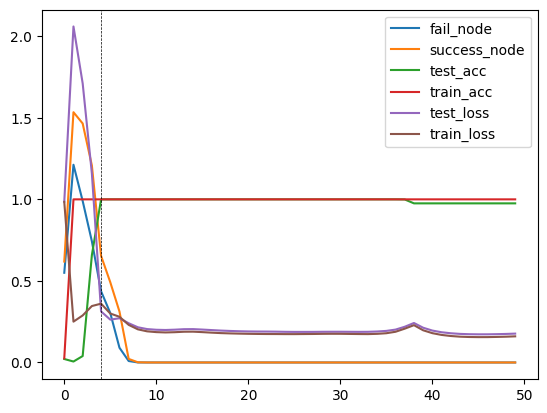

In [24]:
plt.plot(weights_norms["a"][:,6], label="fail_node")
plt.plot(weights_norms["a"][:,5], label="success_node")
plt.plot(stats["test_acc"], label="test_acc")
plt.plot(stats["train_acc"], label="train_acc")

# plt.plot(torch.tensor(stats["test_loss"]).log(), label="test_loss")
# plt.plot(torch.tensor(stats["train_loss"]).log(), label="train_loss")

plt.plot(stats["test_loss"], label="test_loss")
plt.plot(stats["train_loss"], label="train_loss")

# Find when the grokking finished
grok_finished_idx = (torch.tensor(stats["test_acc"]) > 0.99).nonzero()[0][0]
print(grok_finished_idx)
plt.axvline(x=grok_finished_idx, color='k', linewidth=0.5, linestyle="--")

plt.legend()

In [261]:
model["results"][-1]

{'epoch': 0,
 'train_acc': 0.01521164021164021,
 'test_acc': 0.014451686030036838,
 'train_loss': 0.9907954335212708,
 'test_loss': 0.9915350079536438}

In [19]:
second_der_fail = second_derivative(smooth_1d(weight_norms["a"][:,2]))
second_der_success = second_derivative(smooth_1d(weight_norms["a"][:,100]))

plt.plot(weight_norms["a"][2:150,2], 'r', label="fail_node")
plt.plot(weight_norms["a"][2:150,100], 'b', label="success_node")

plt.plot(second_der_fail[2:150] * 100, 'r--', label="fail_node_2nd")
plt.plot(second_der_success[2:150] * 100, 'b--', label="success_node_2nd")

plt.axhline(y=0, color='k', linewidth=0.5)

plt.legend()

NameError: name 'second_derivative' is not defined

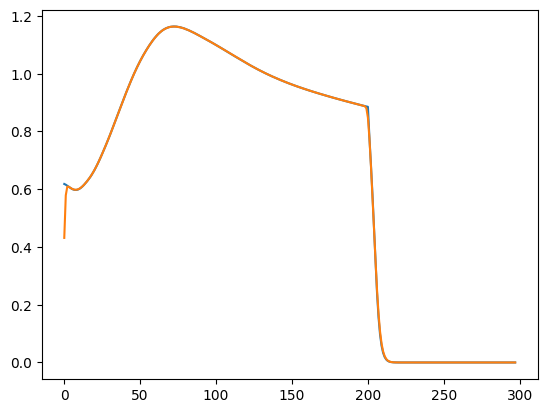

In [95]:
plt.plot(weight_norms["a"][:,2])
plt.plot(smooth_1d(weight_norms["a"][:,2]))

In [13]:
import random

complex_type = torch.cdouble
real_type = torch.double

d = weights["a"].size(2)
# Fourier bases

v = torch.ones(d, dtype=complex_type)
# unit 
for i in range(d):
    v[i].real = math.cos(2 * math.pi * i / d)
    v[i].imag = math.sin(2 * math.pi * i / d)
    
U = torch.zeros(d, d, dtype=complex_type, requires_grad=False)
for i in range(d):
    U[:,i] = v ** i / math.sqrt(d)
    
U = U.conj()

torch.Size([95])


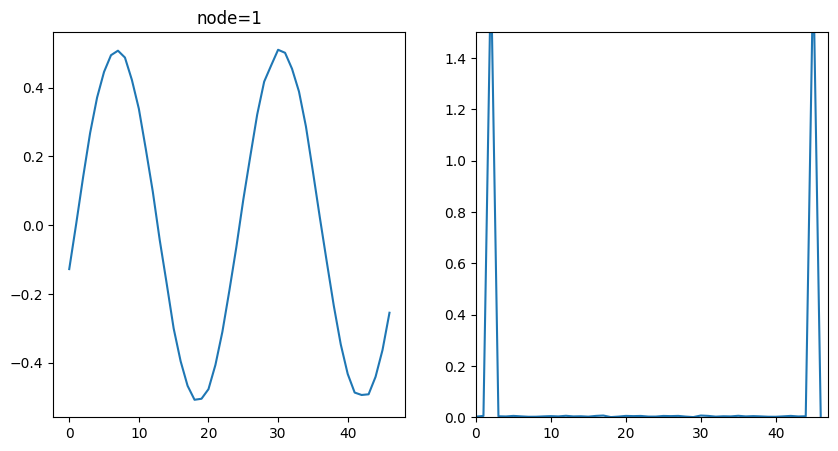

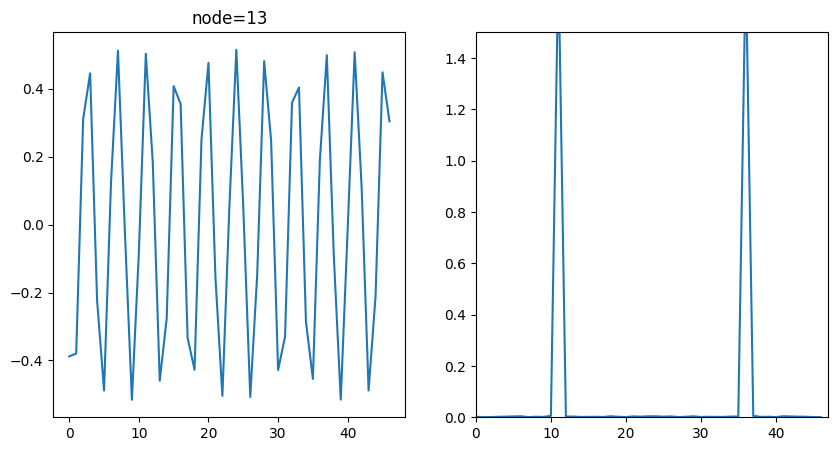

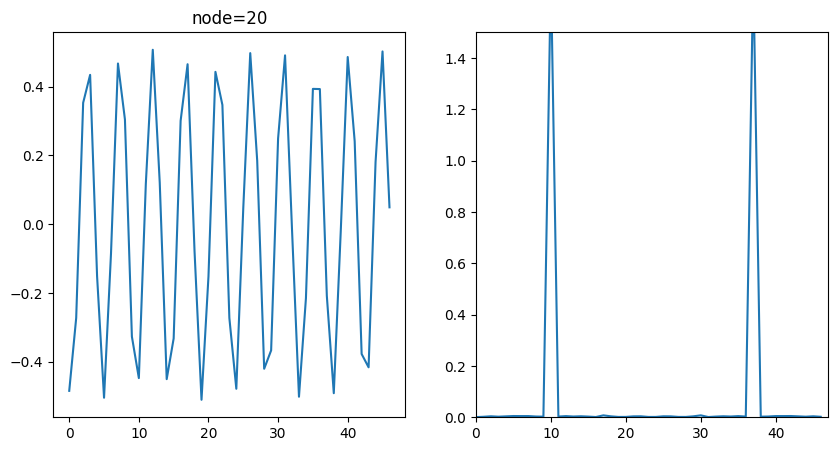

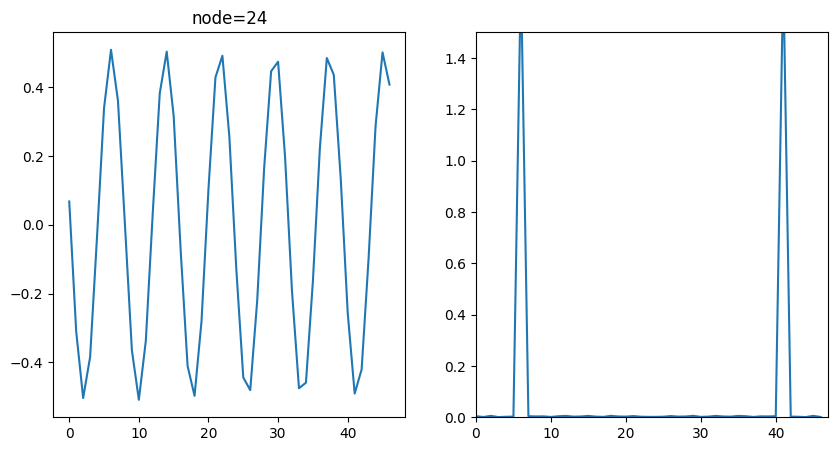

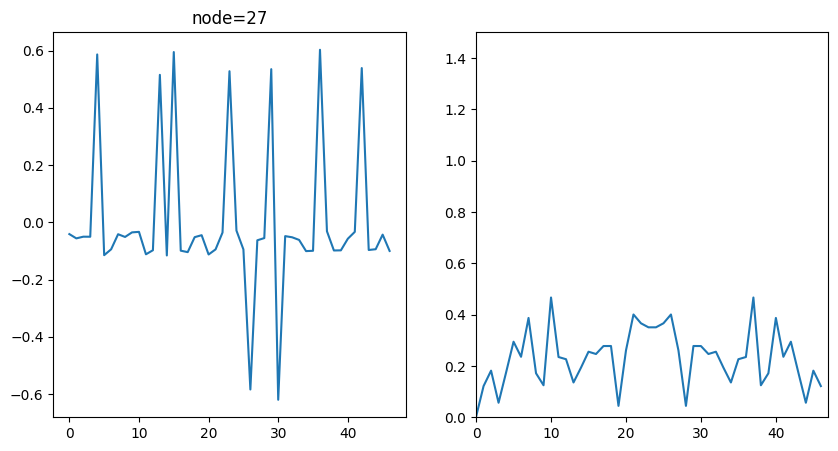

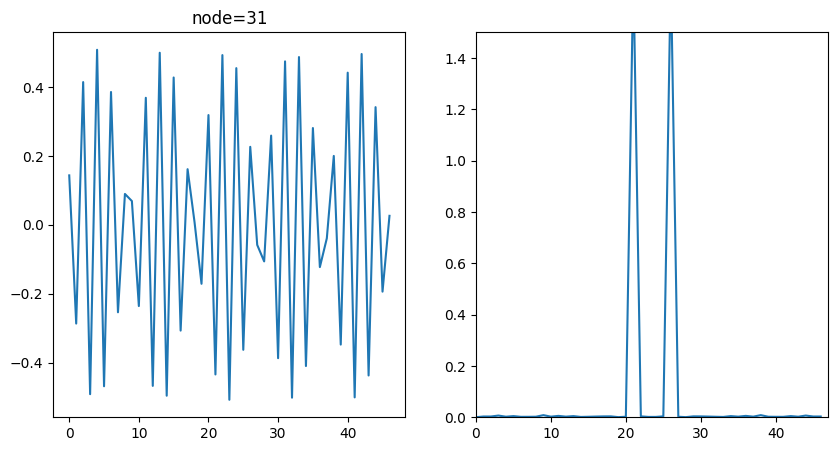

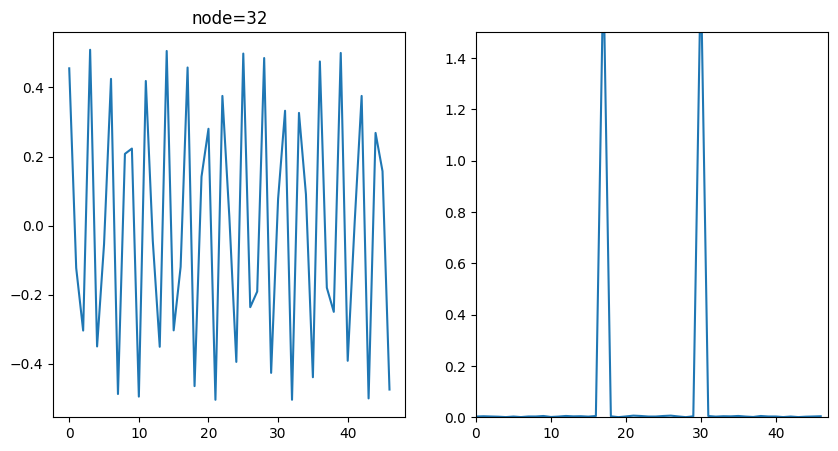

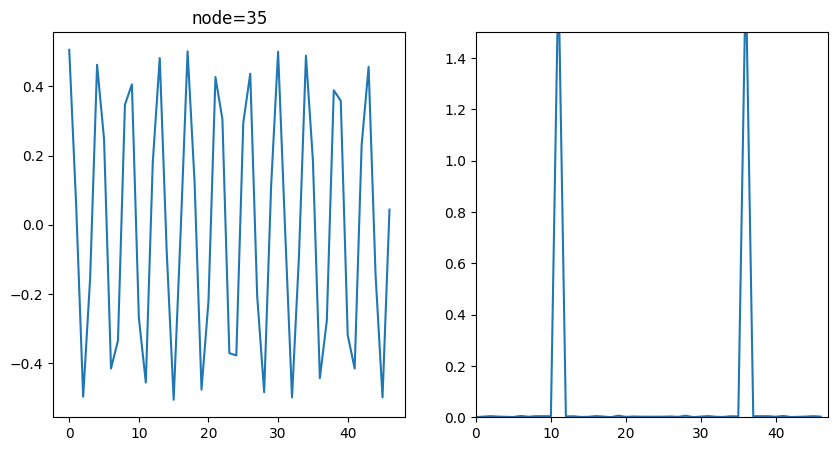

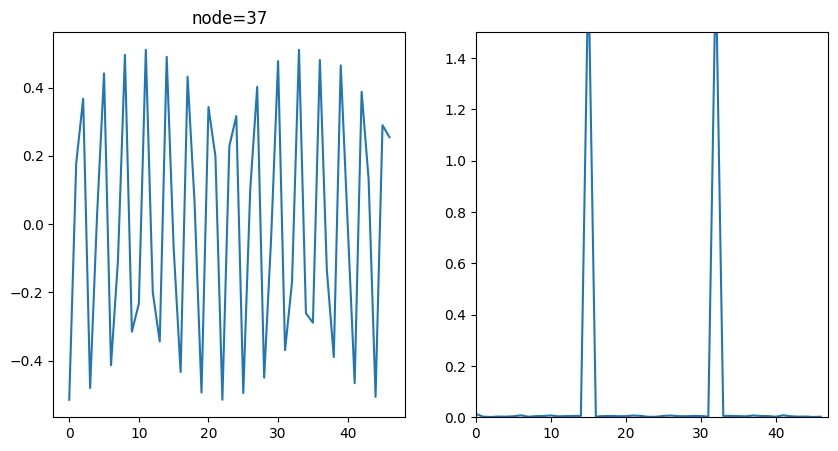

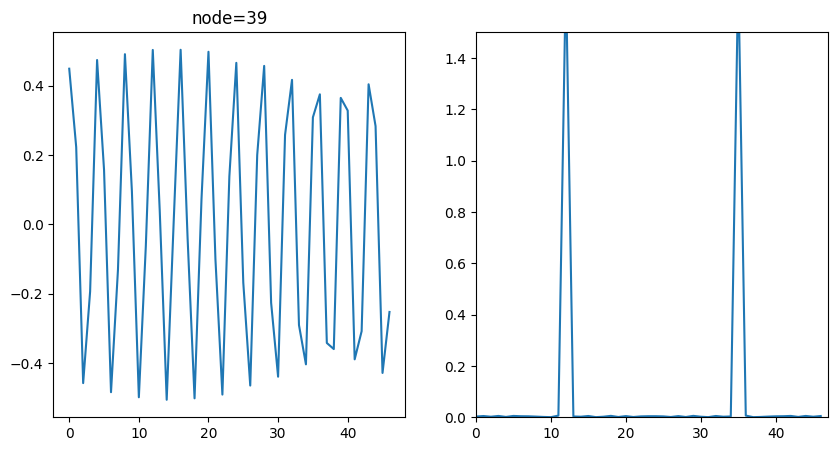

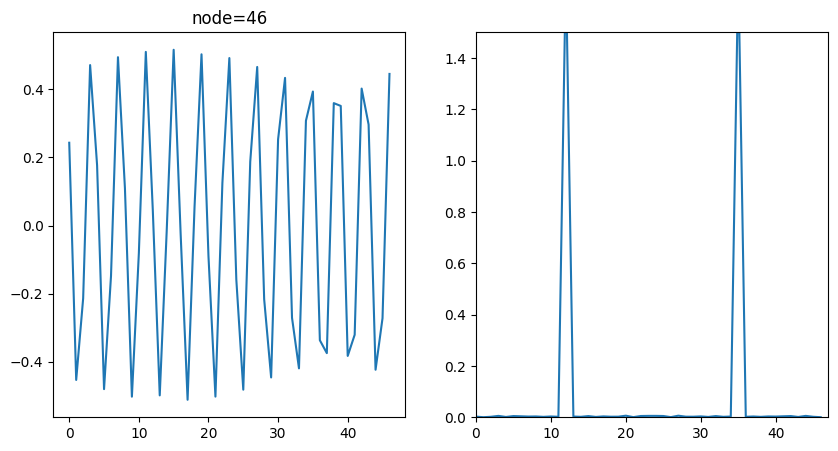

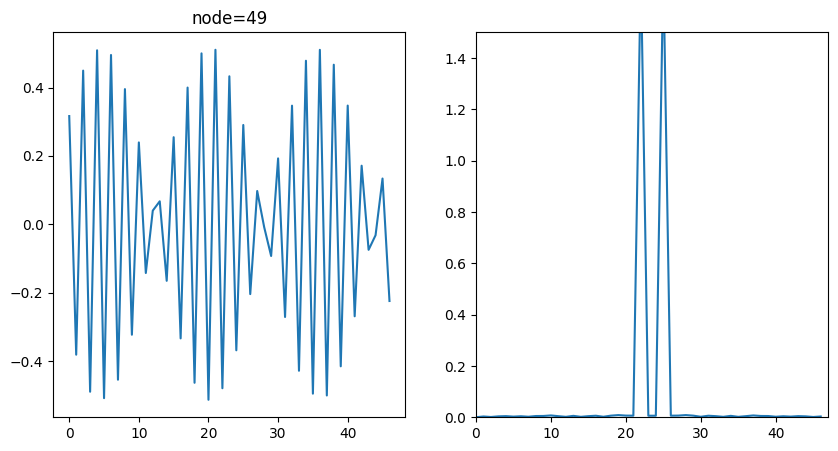

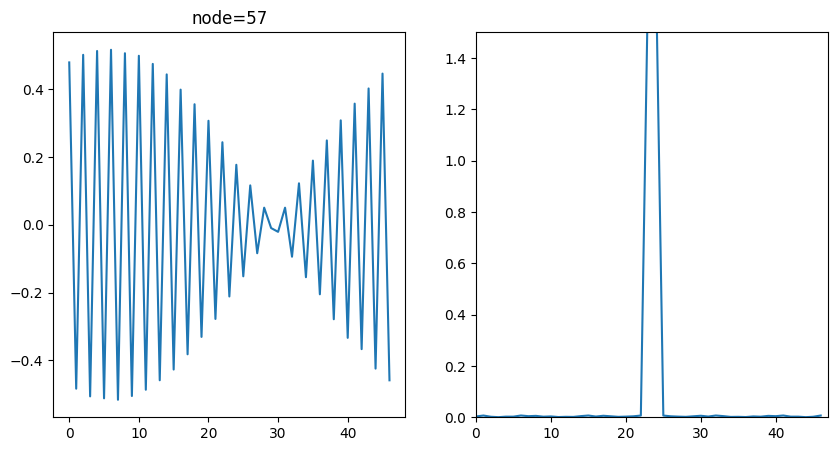

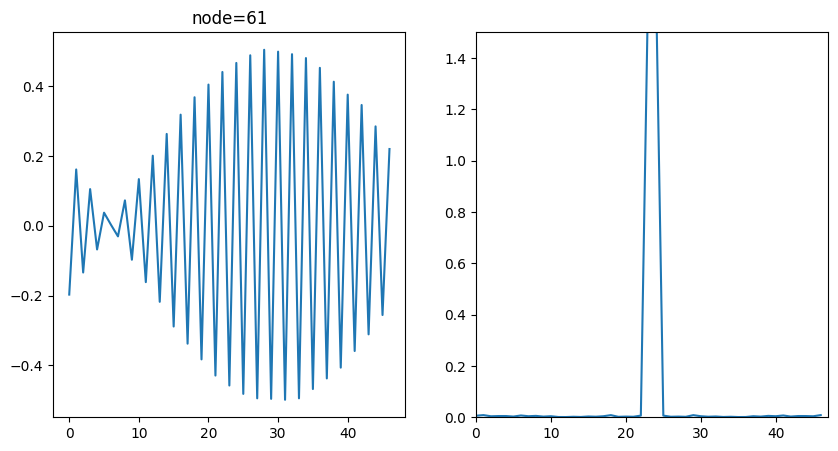

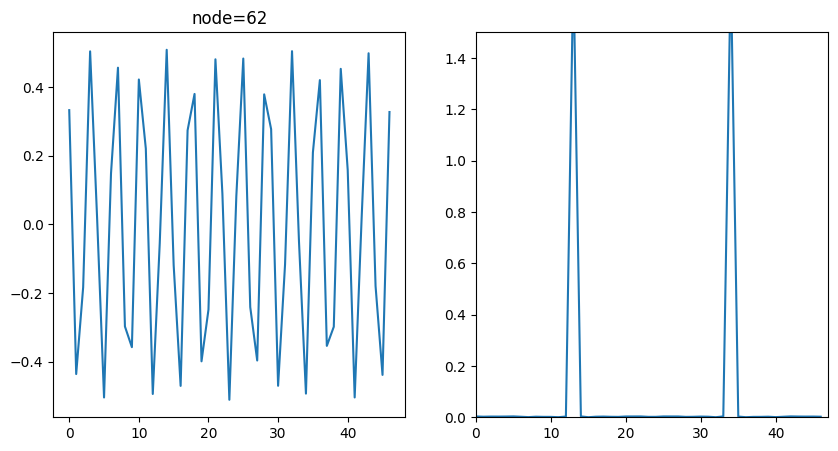

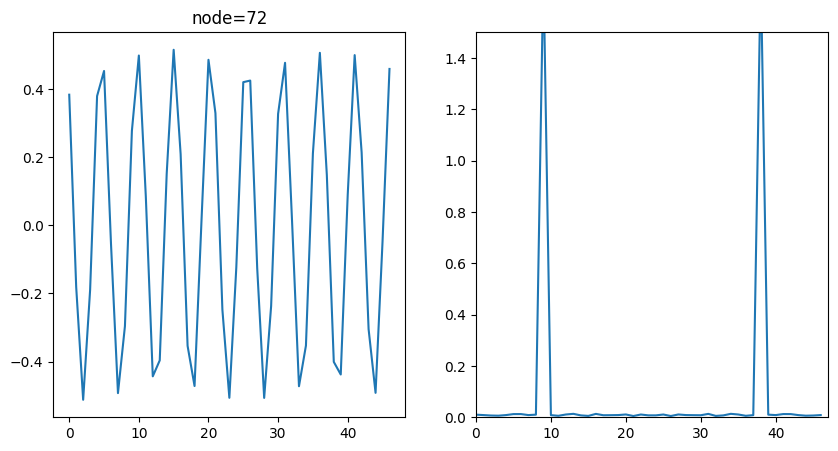

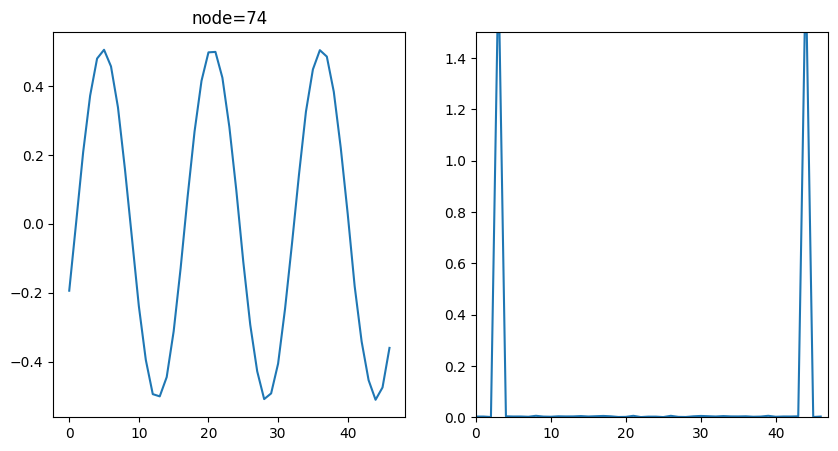

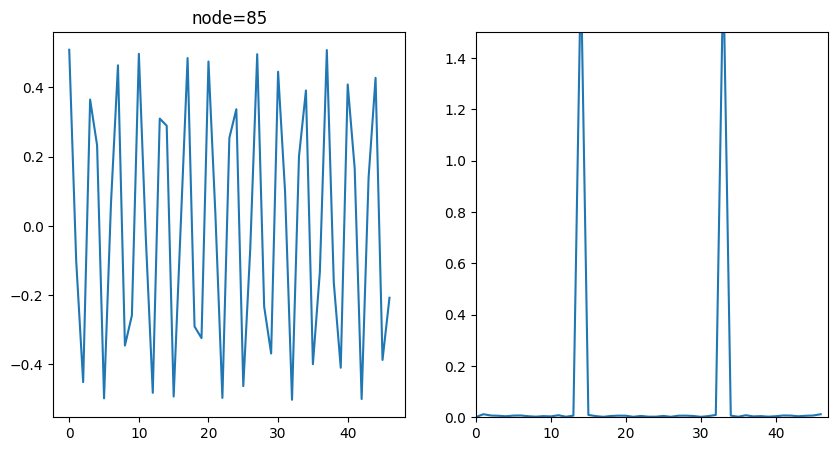

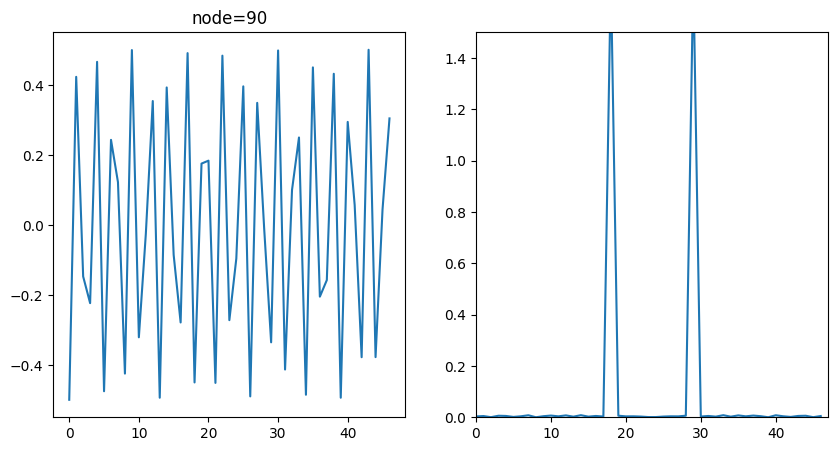

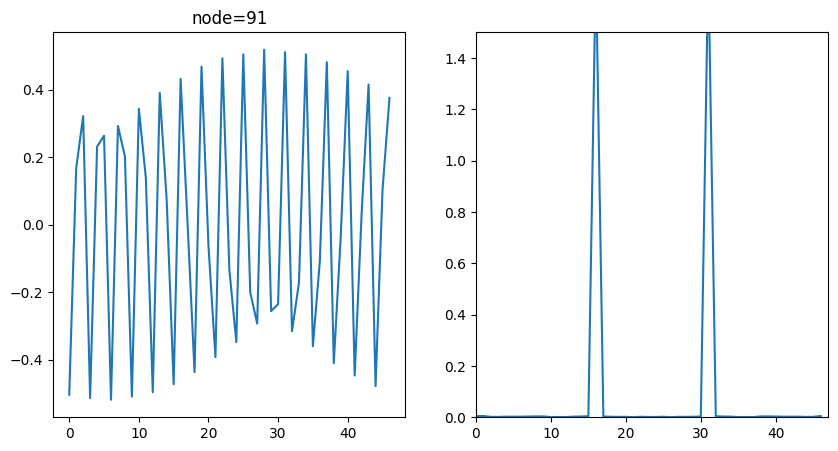

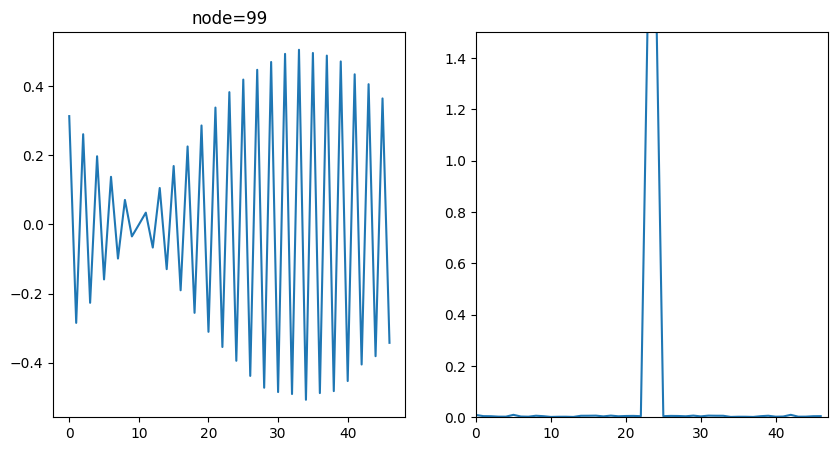

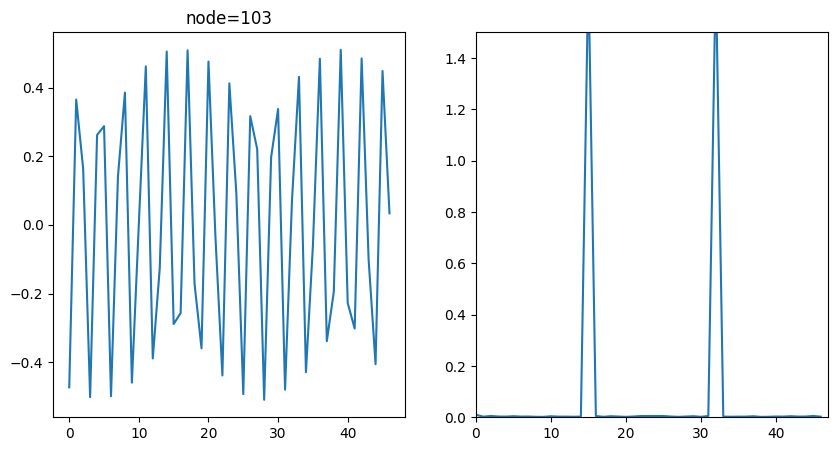

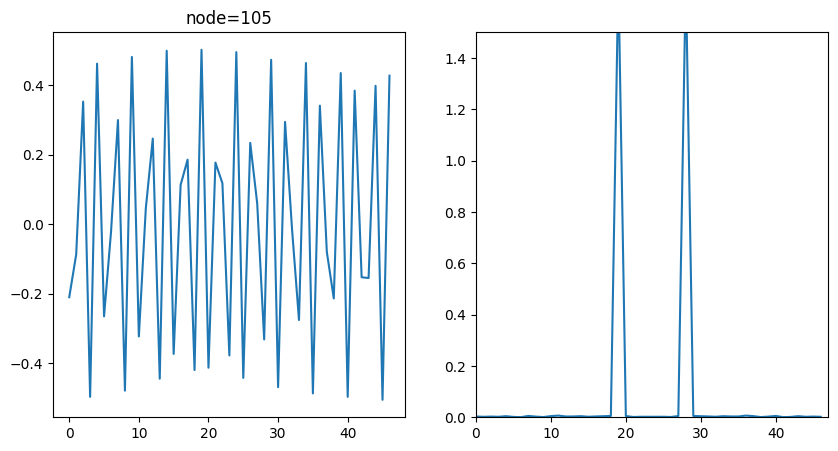

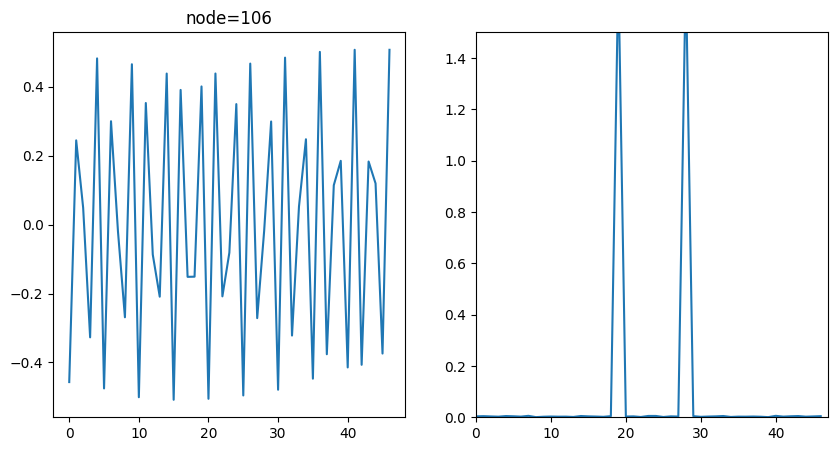

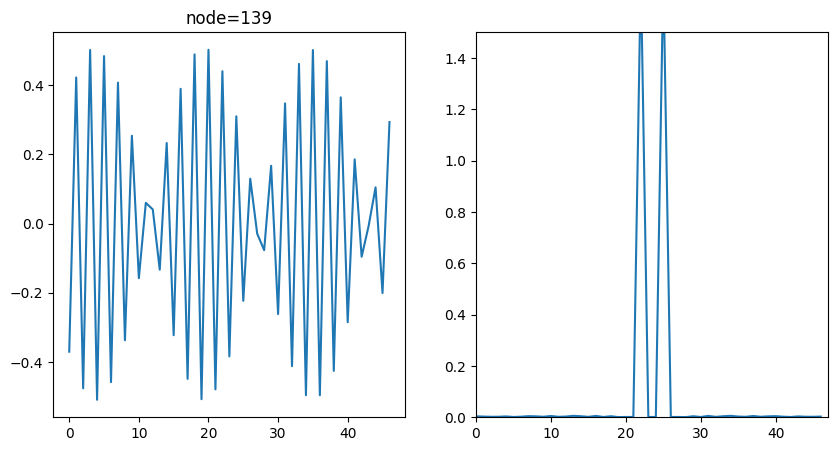

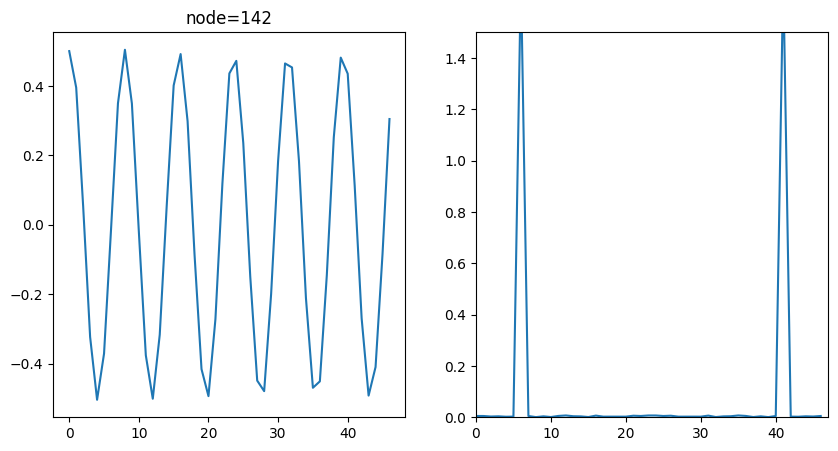

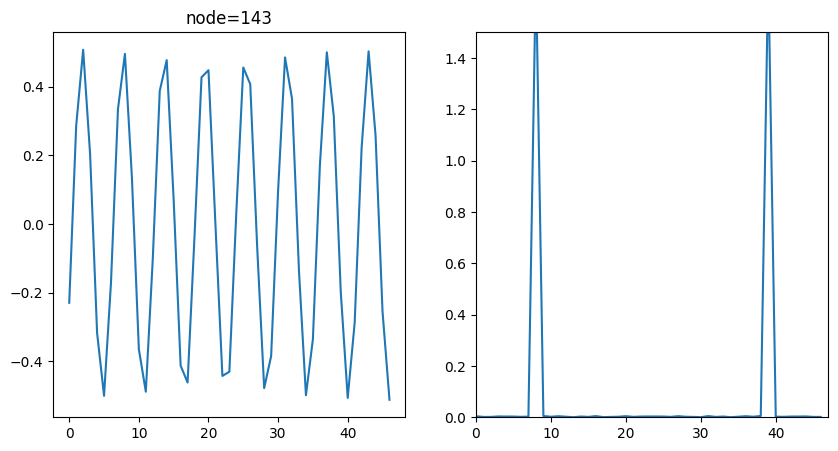

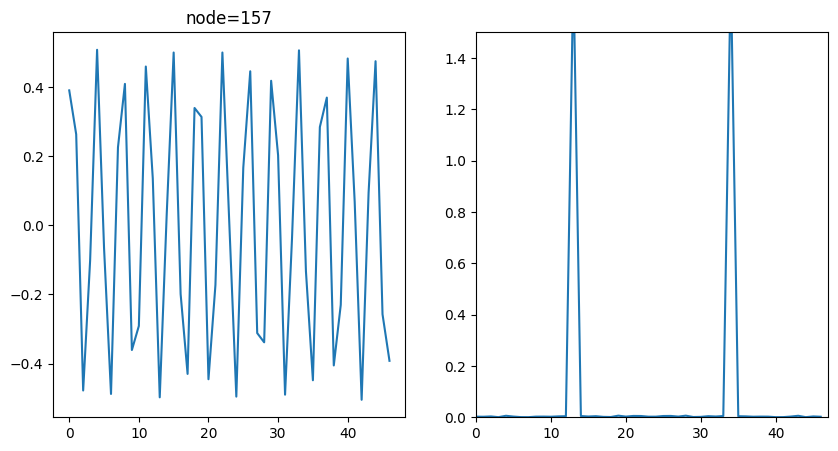

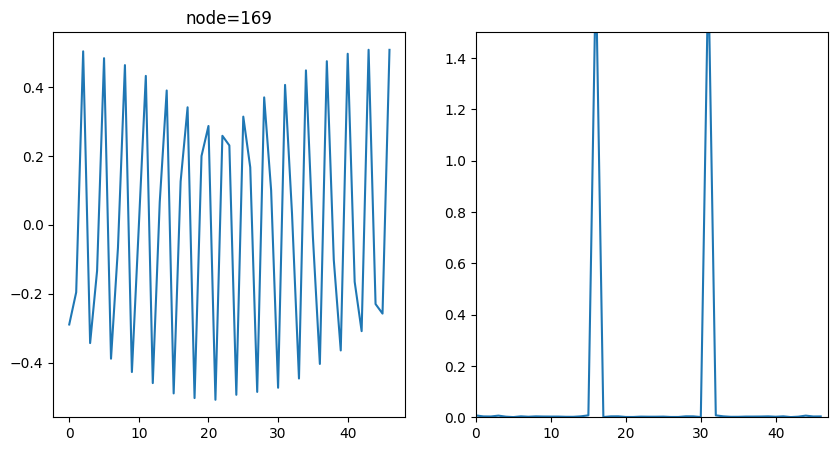

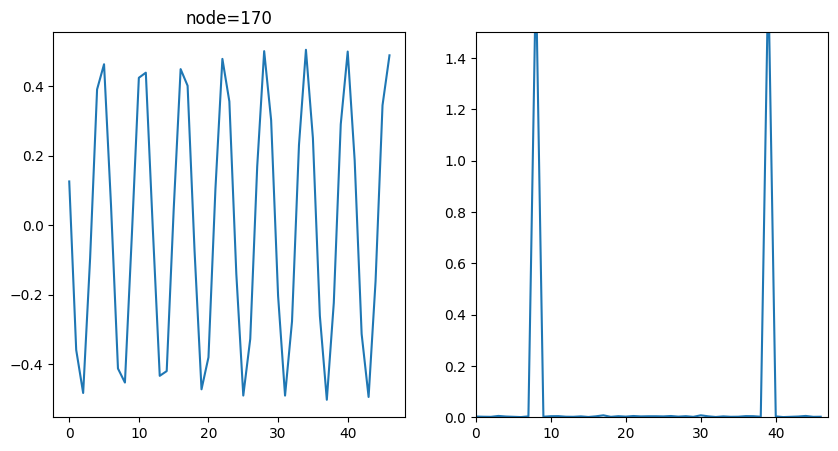

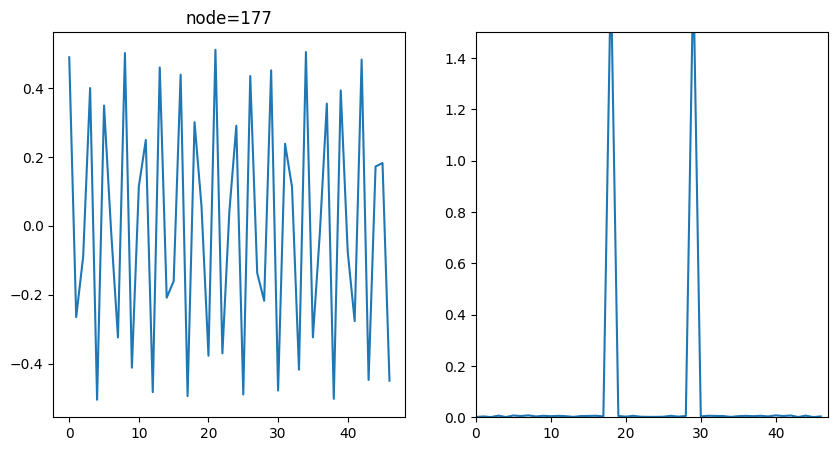

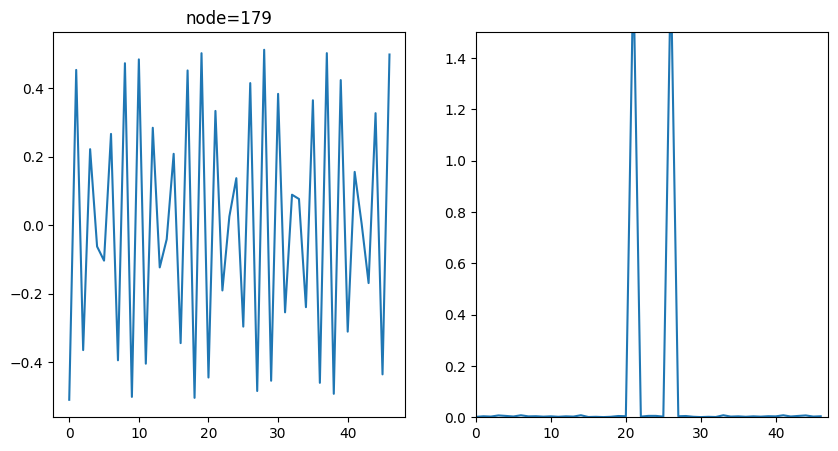

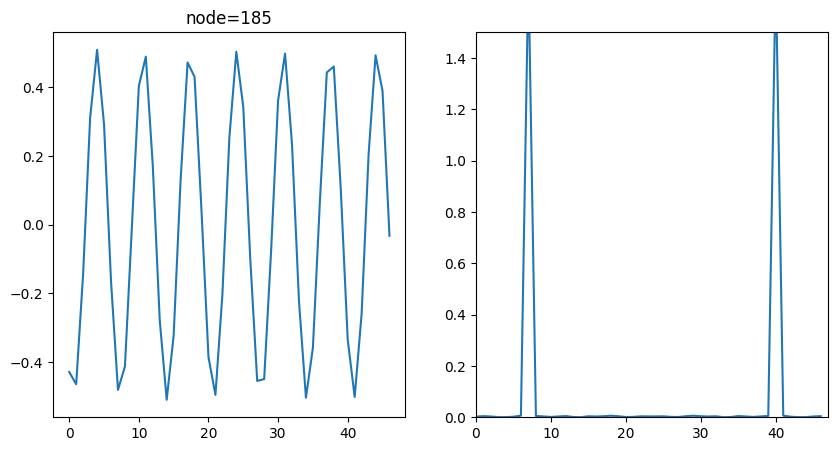

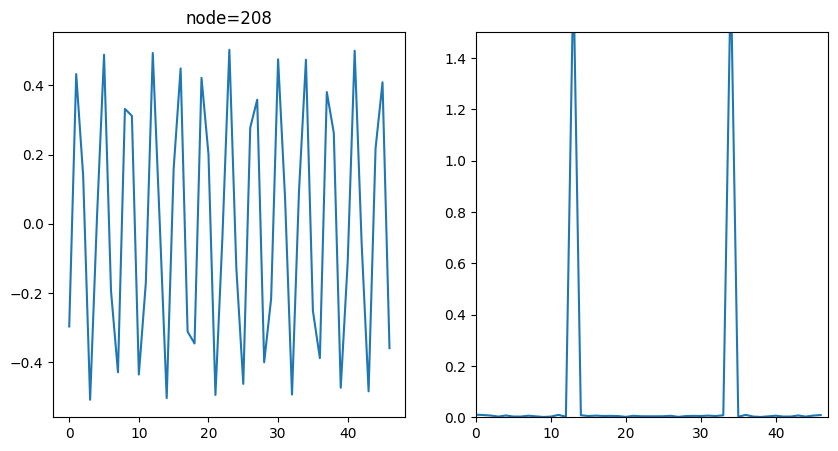

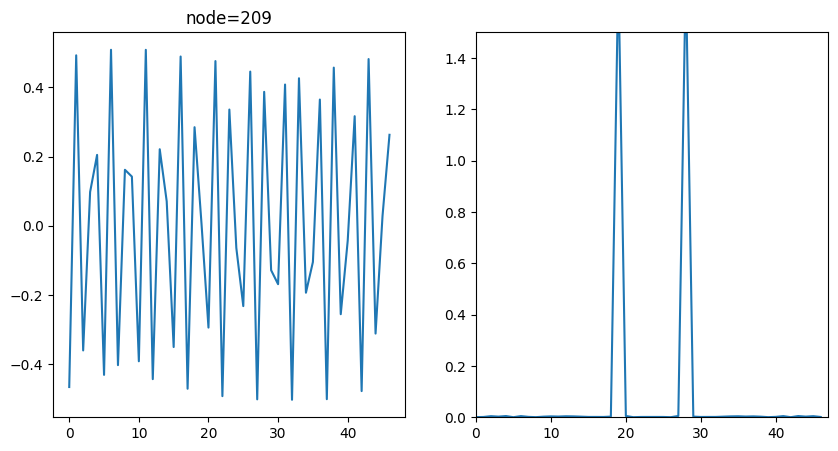

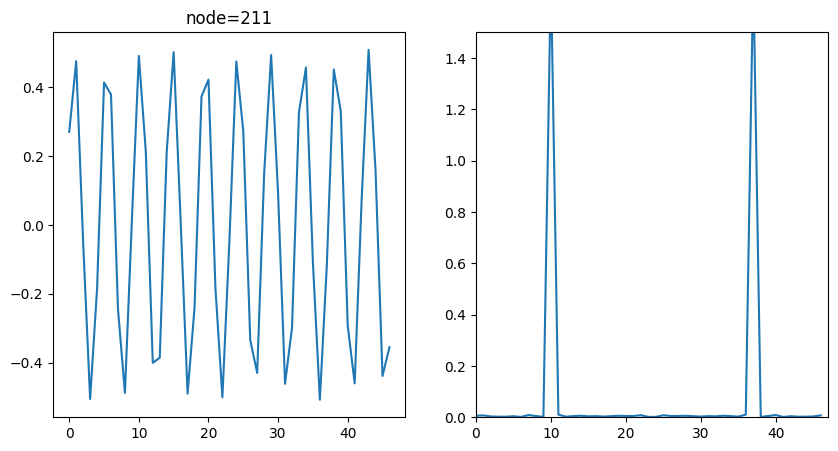

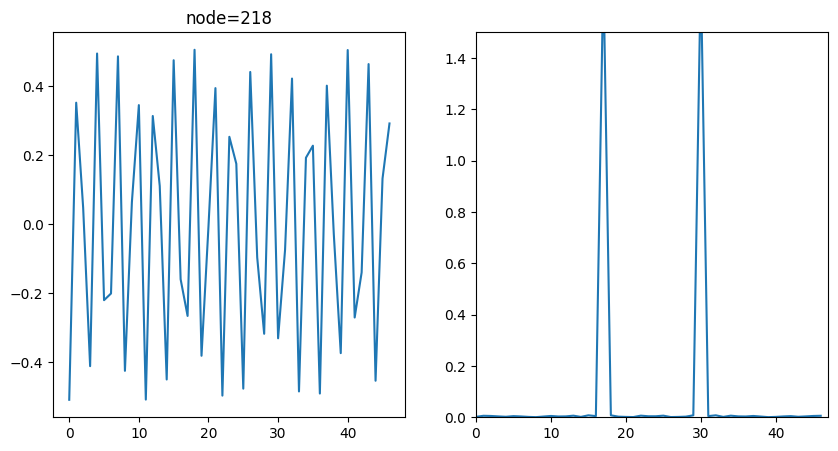

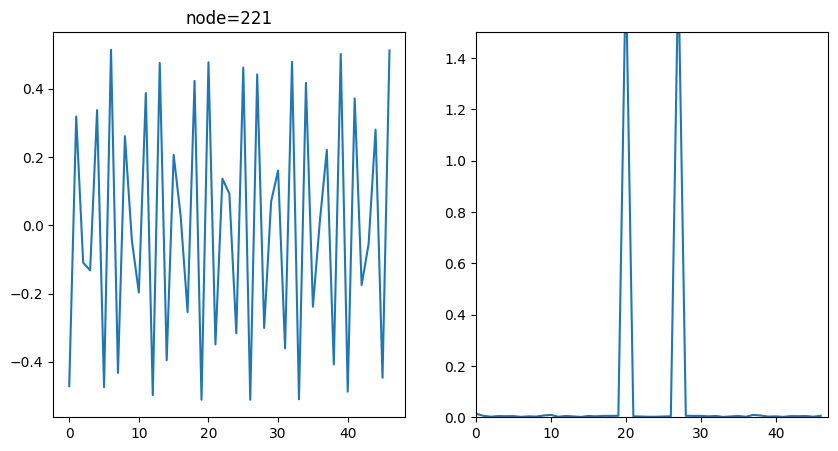

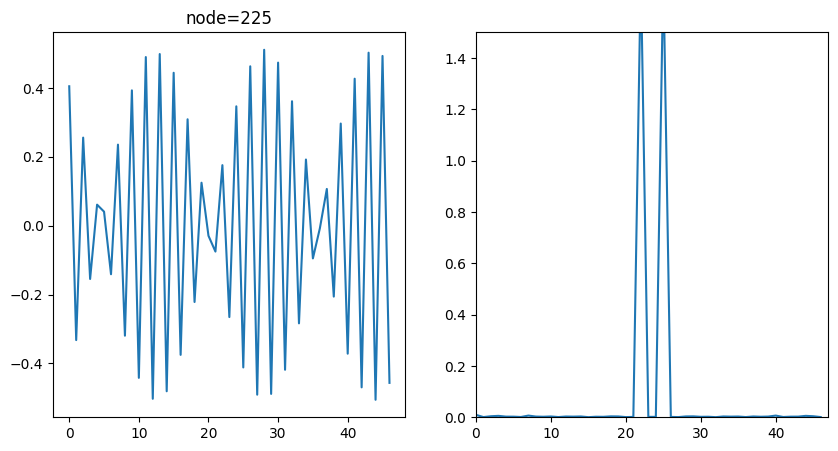

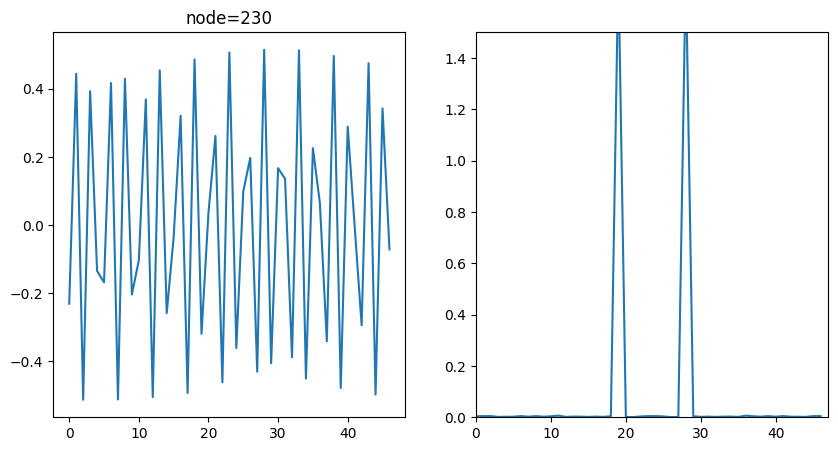

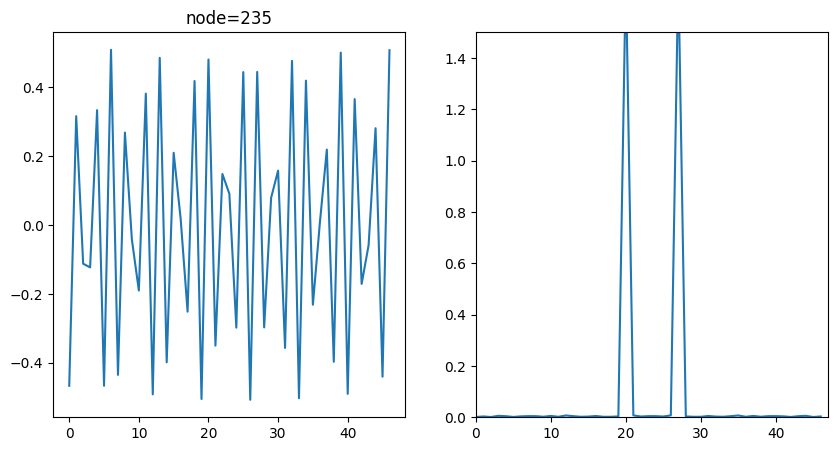

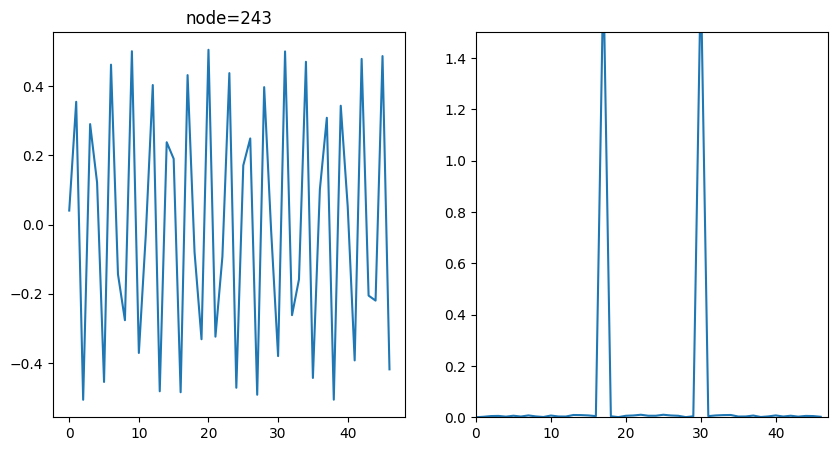

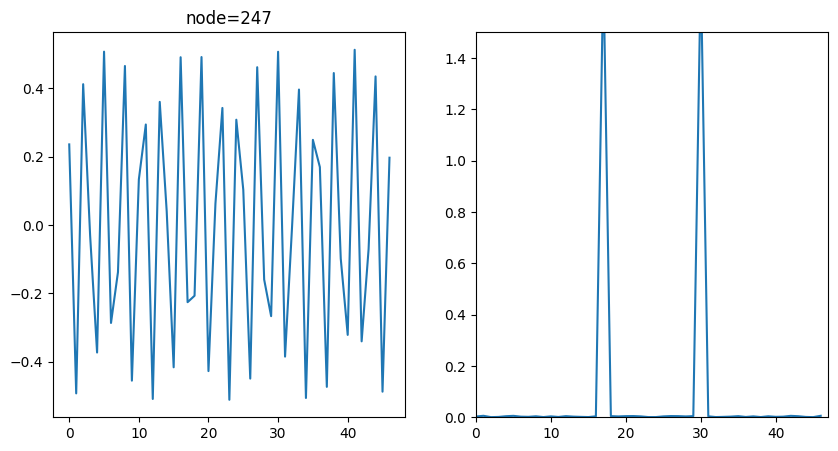

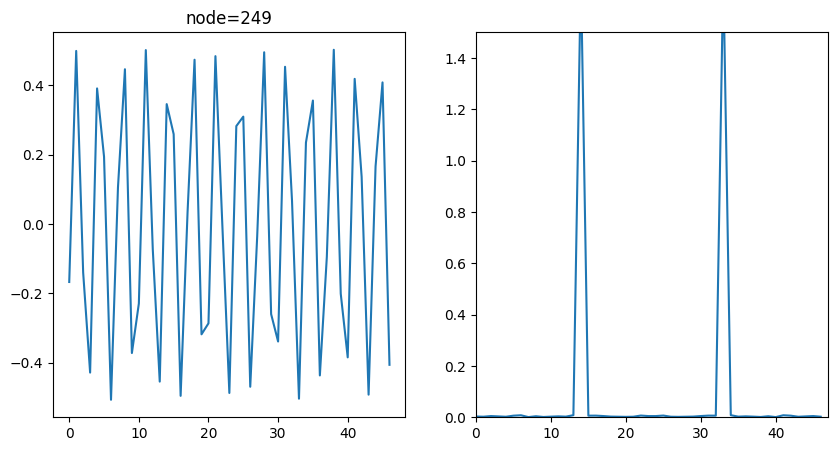

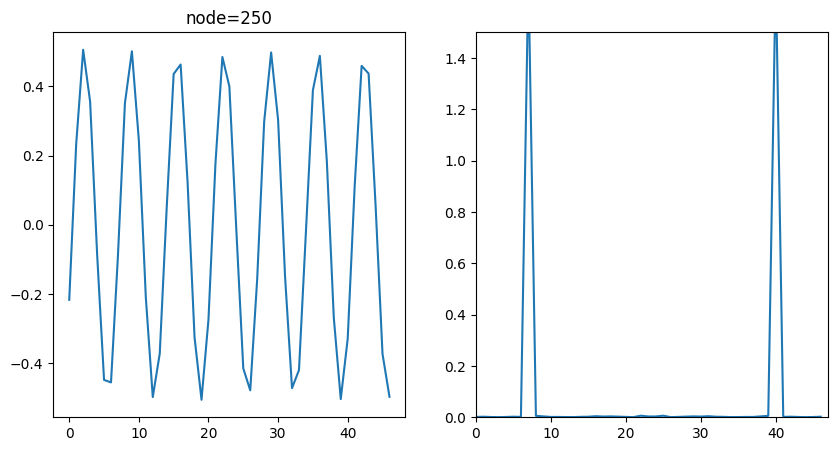

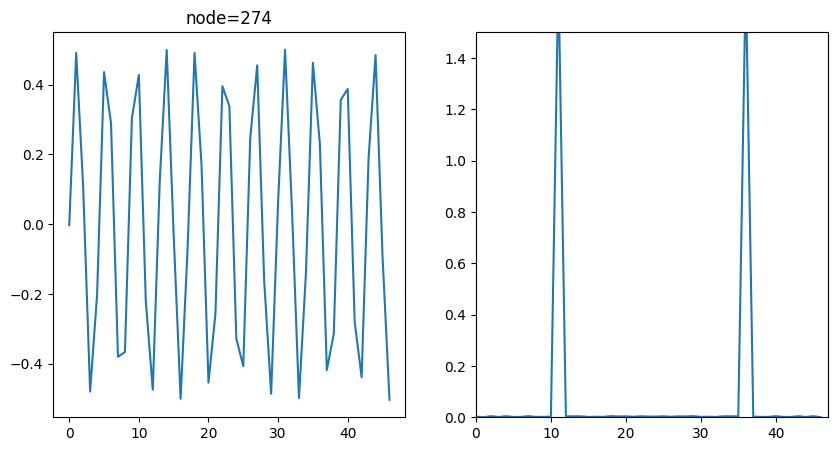

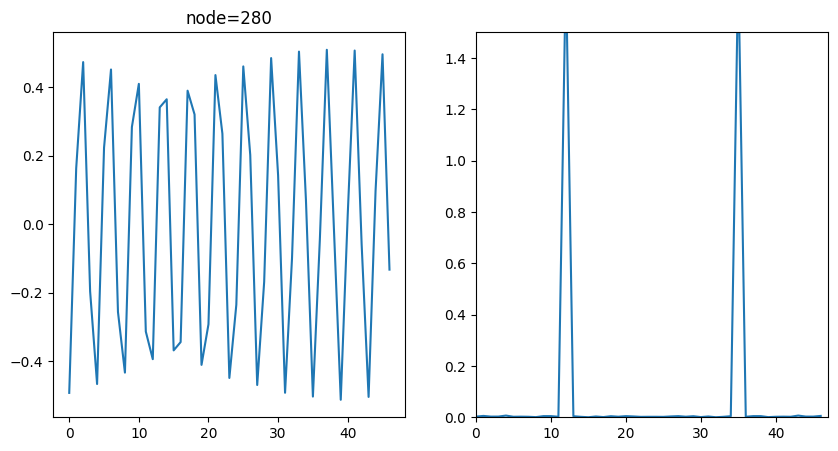

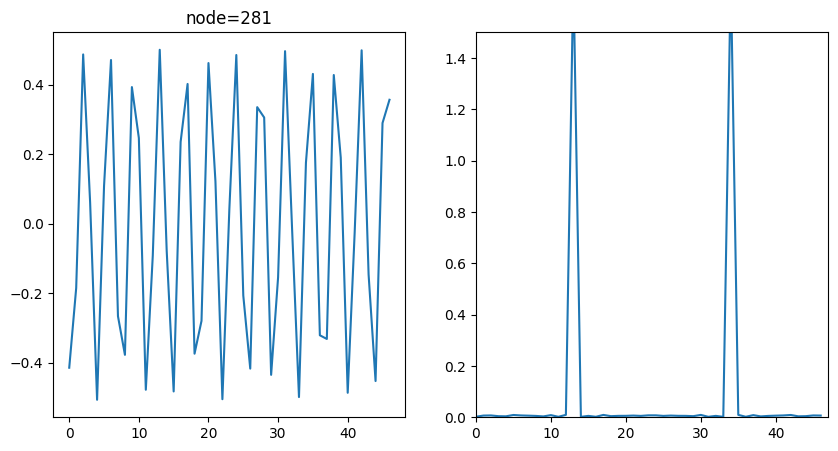

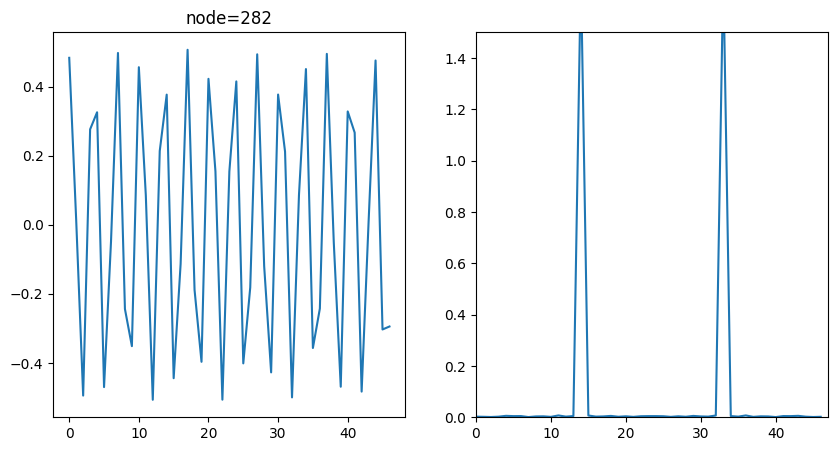

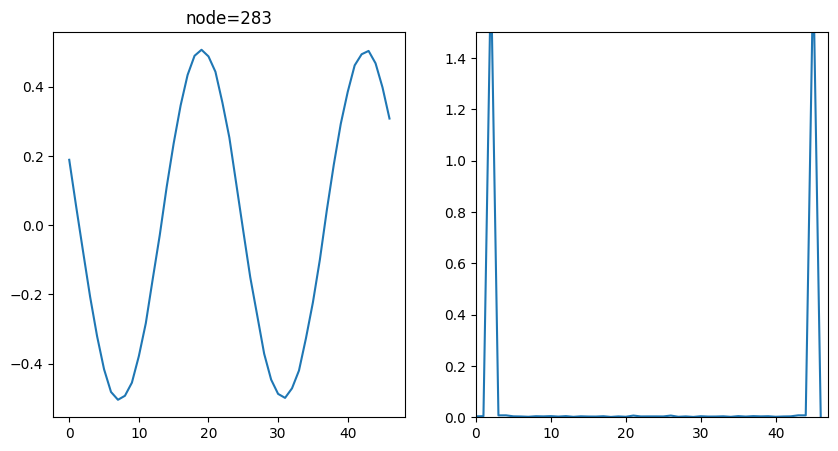

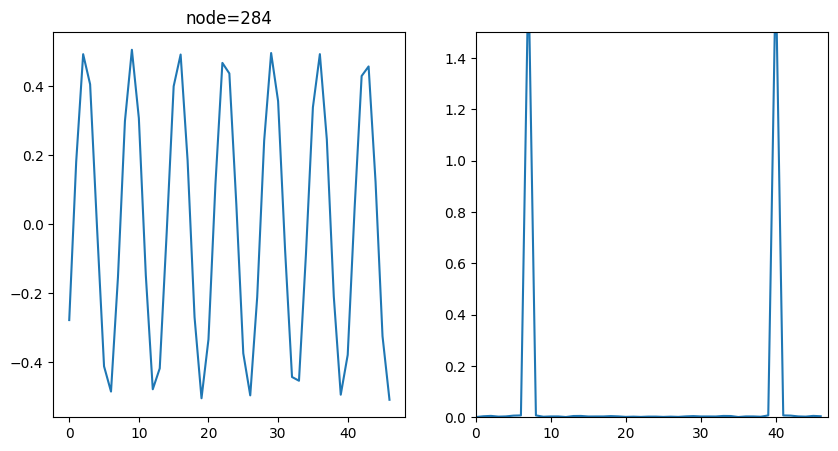

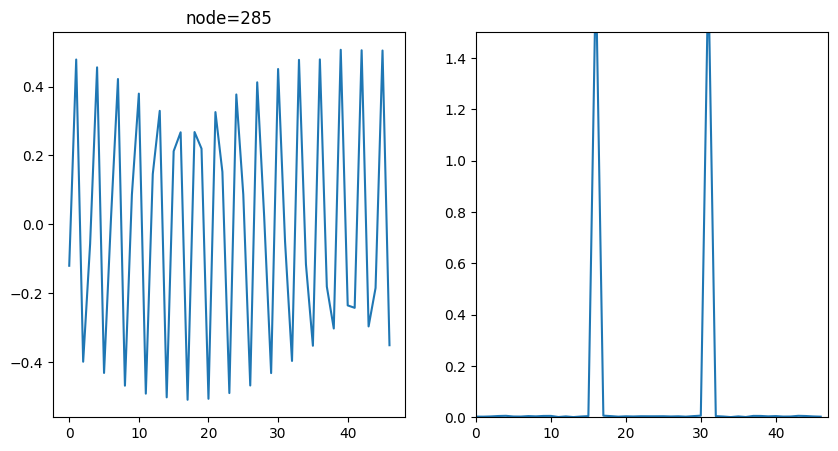

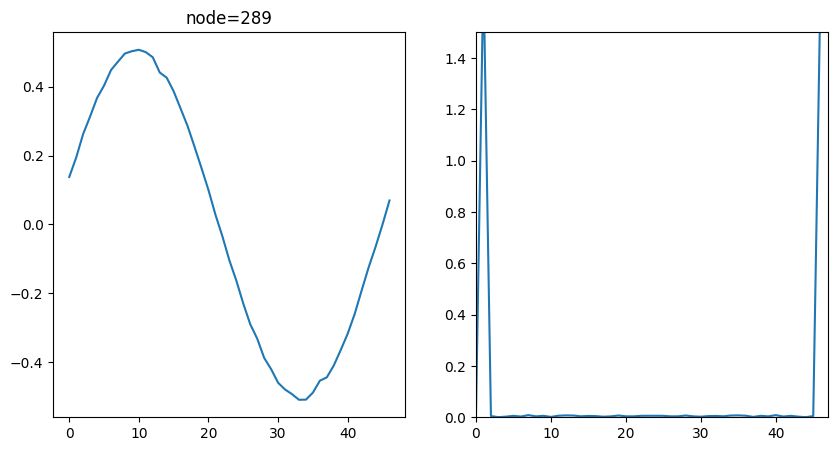

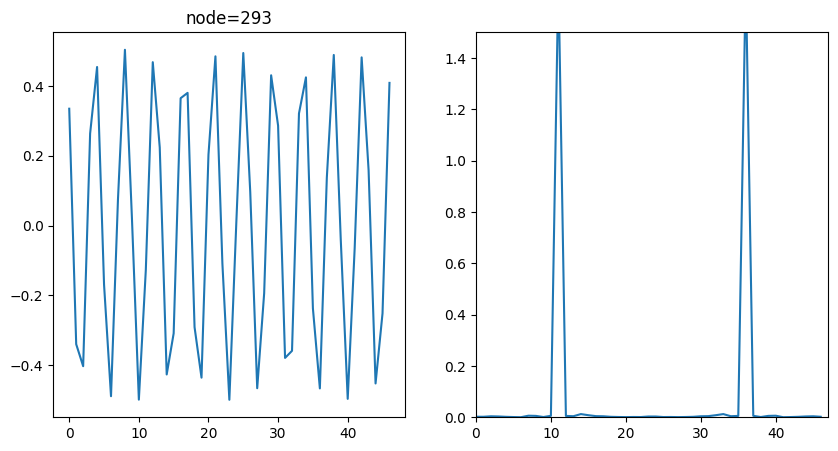

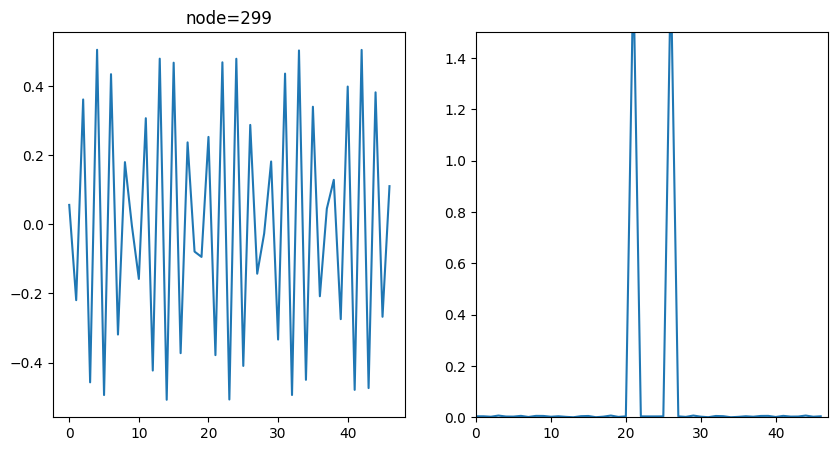

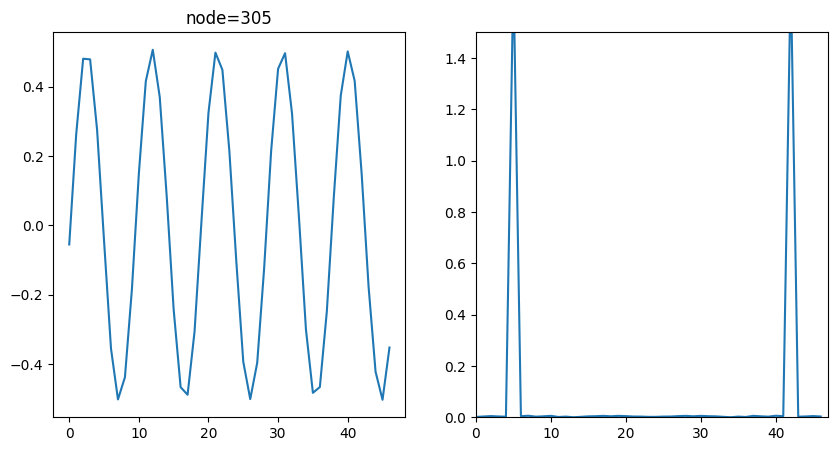

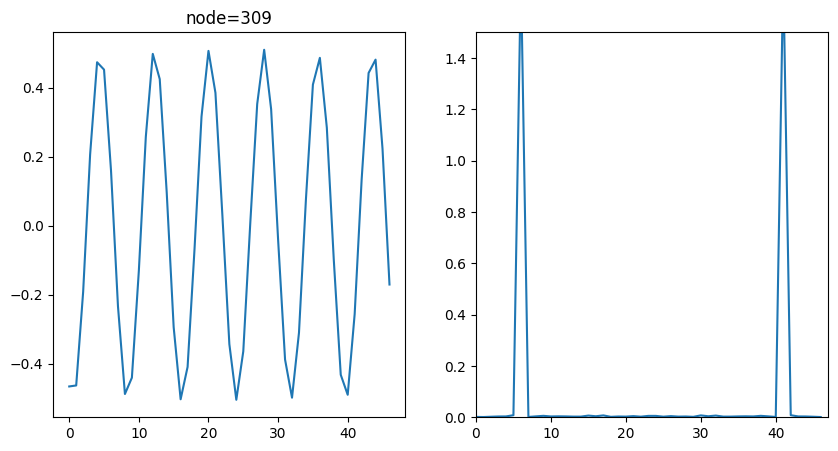

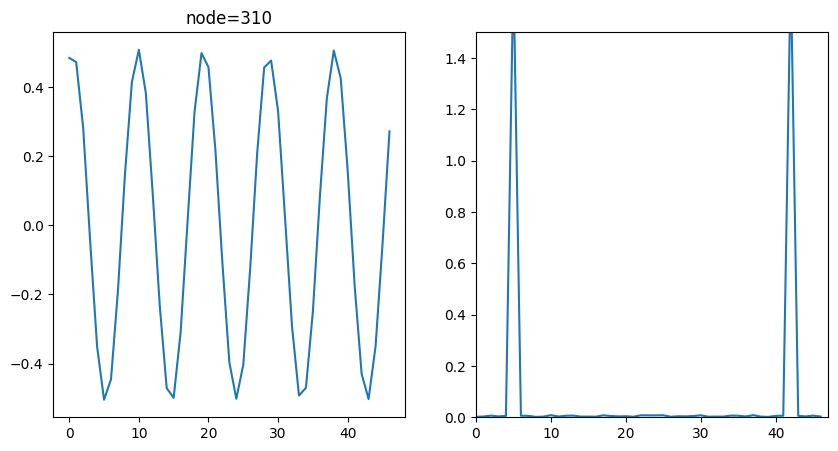

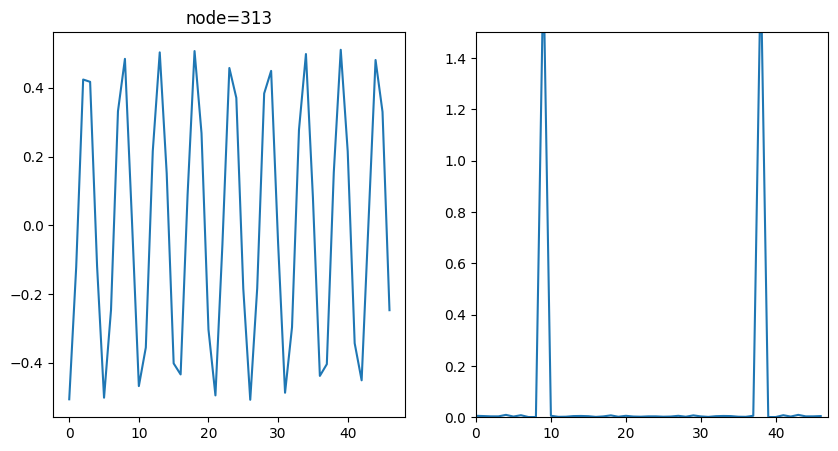

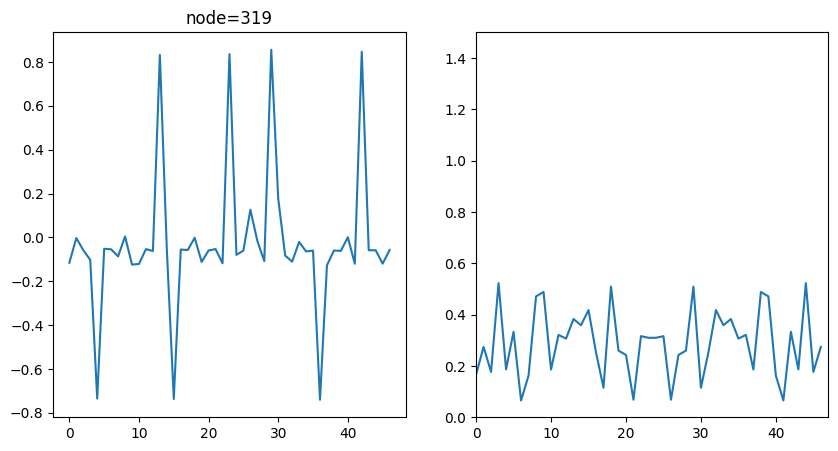

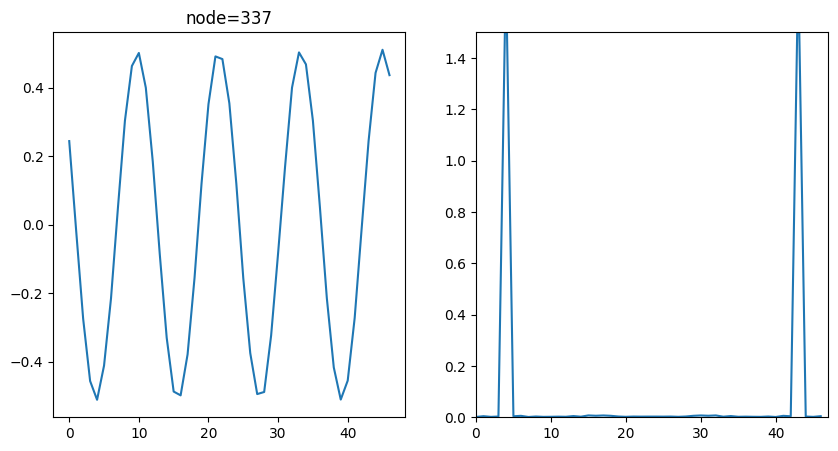

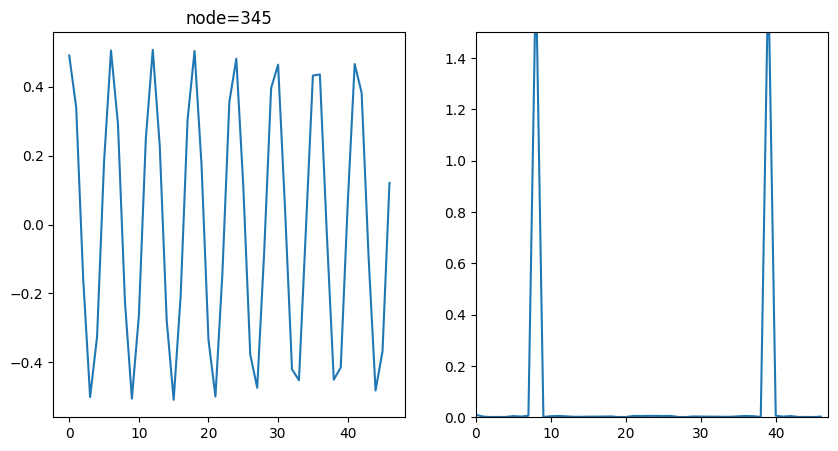

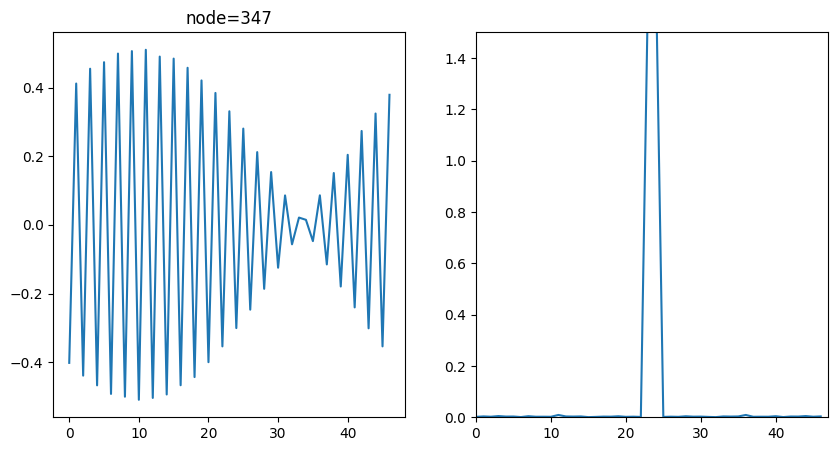

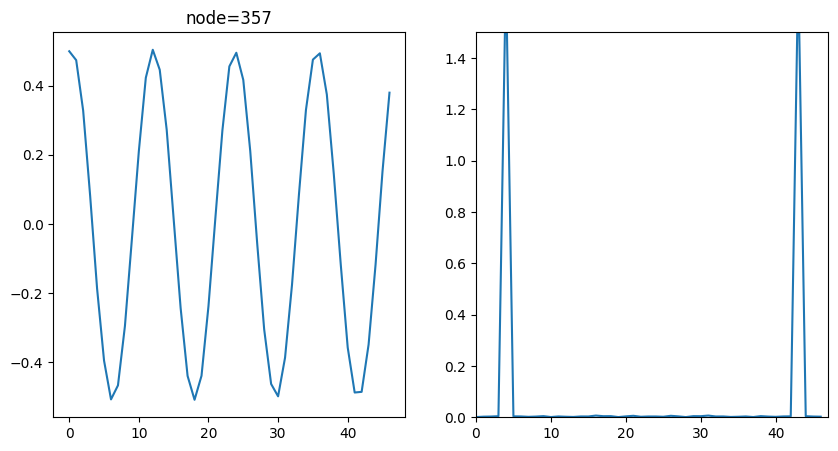

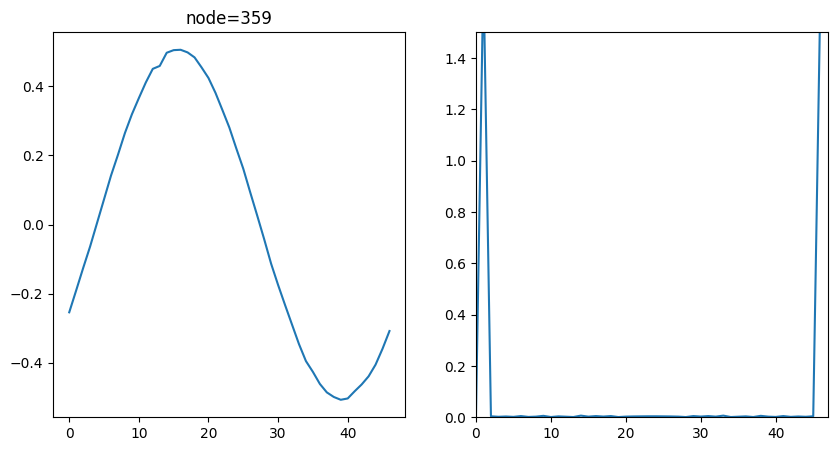

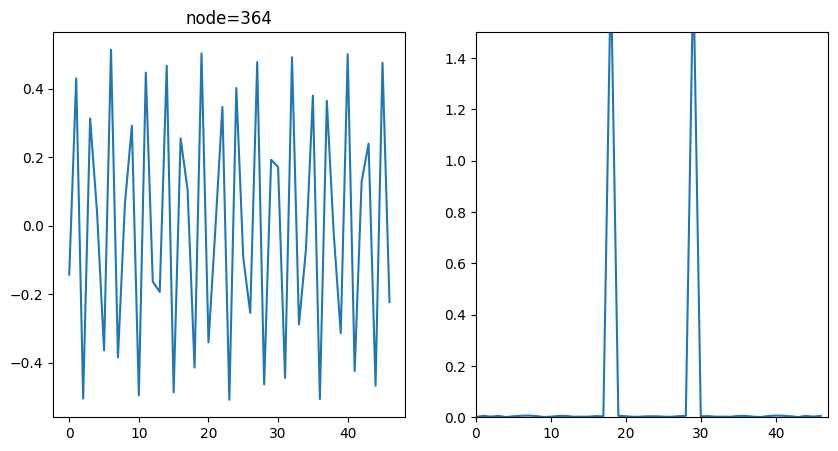

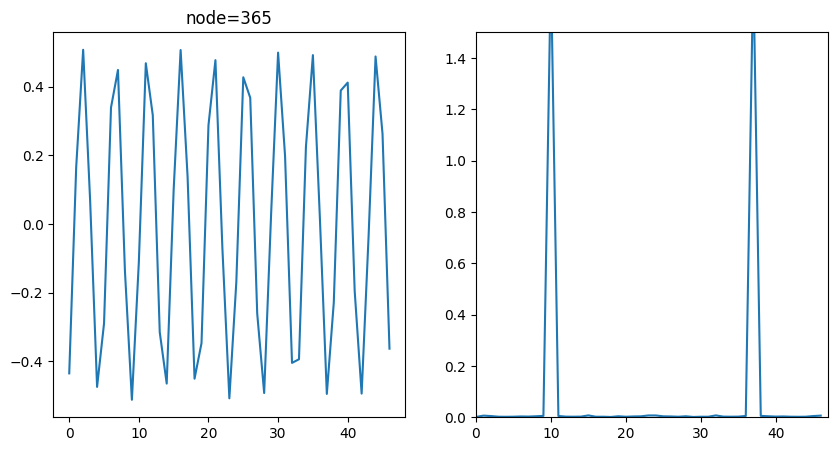

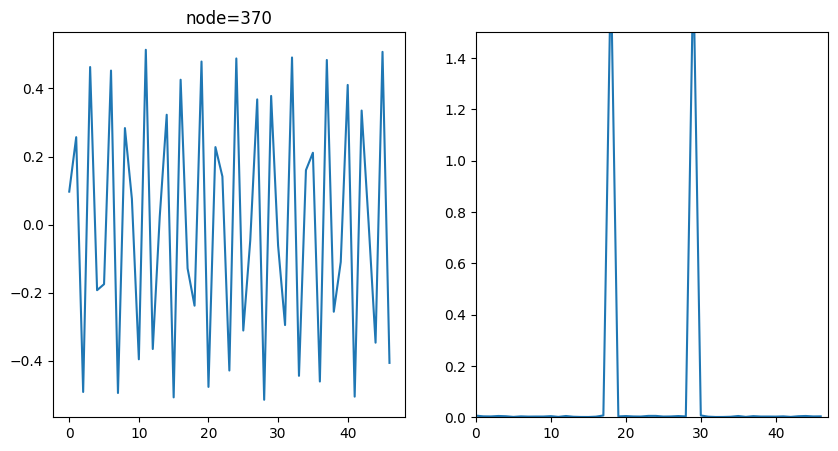

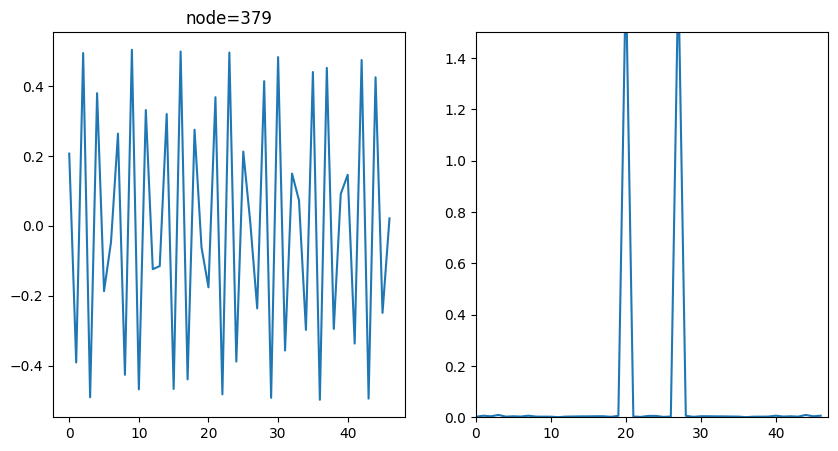

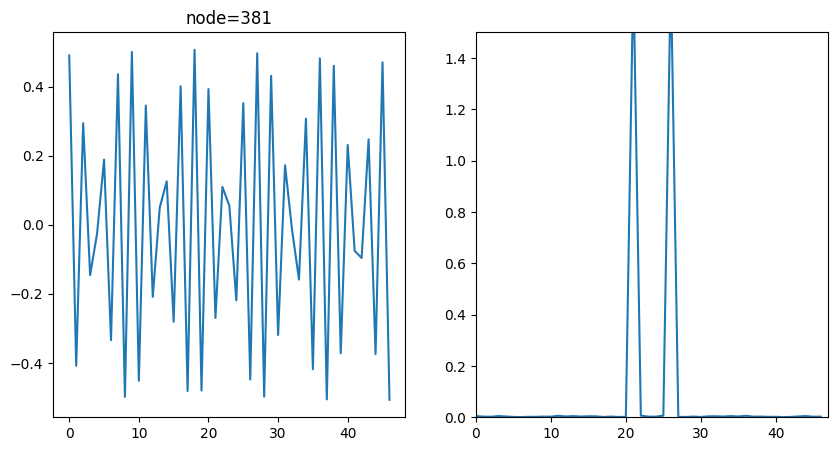

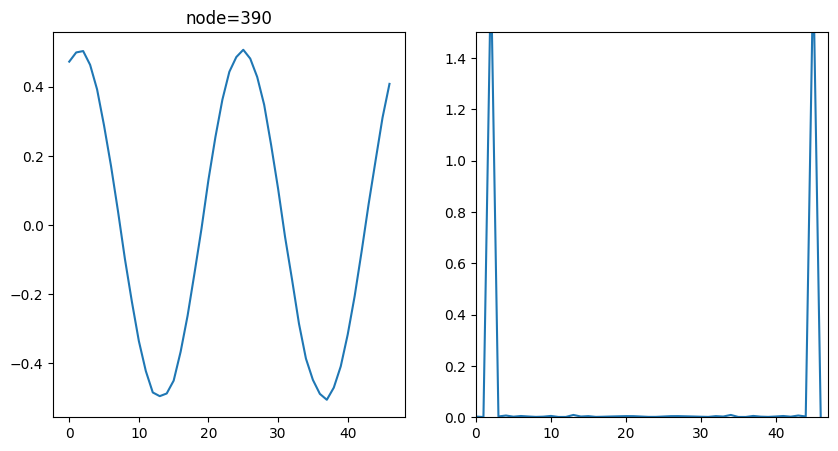

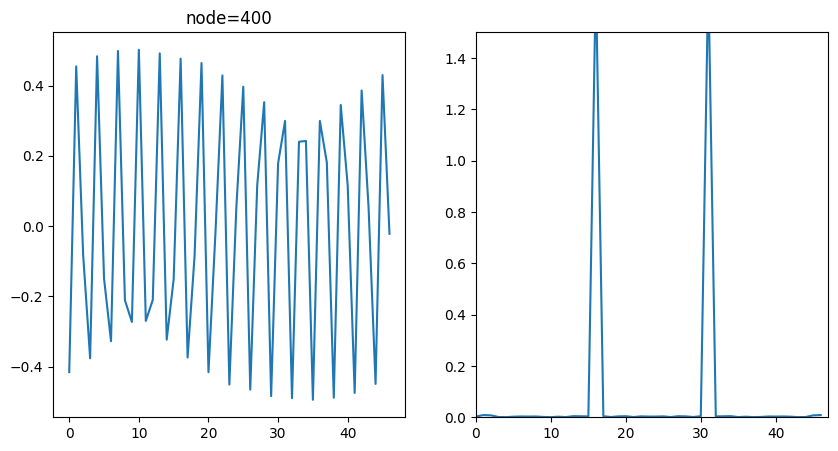

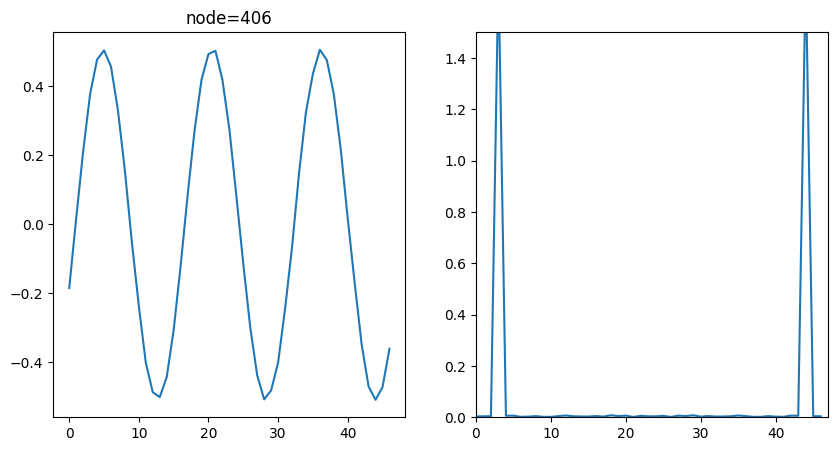

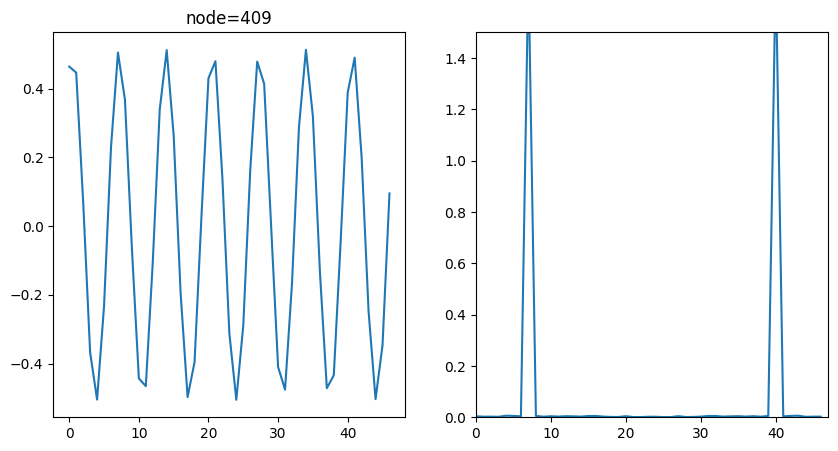

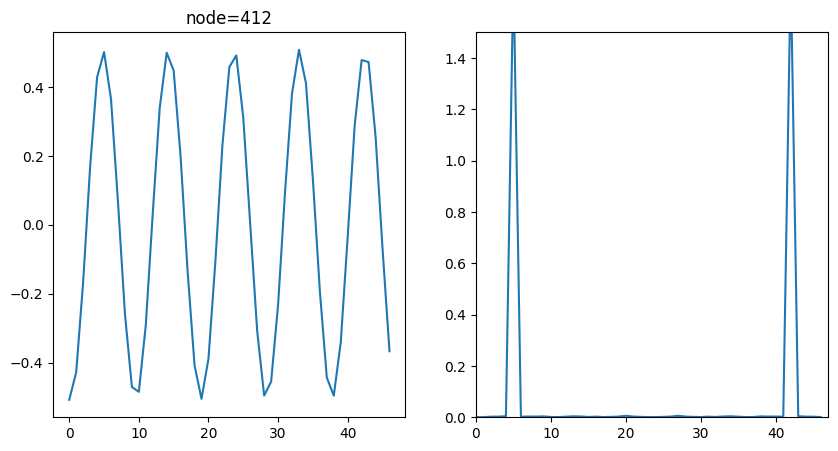

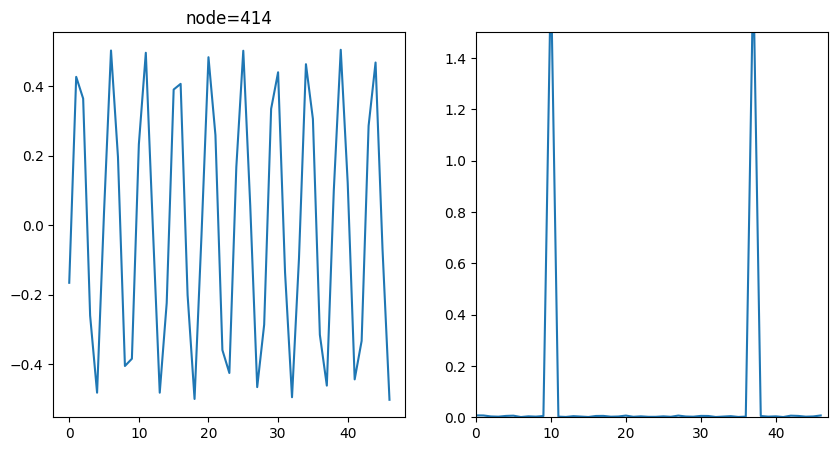

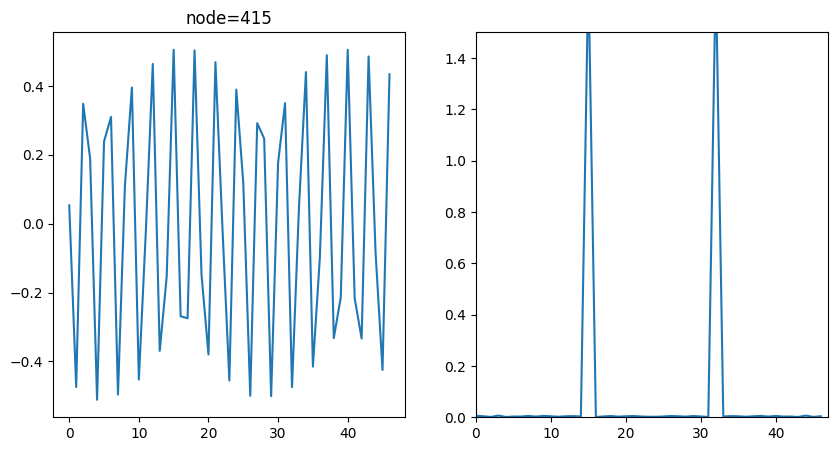

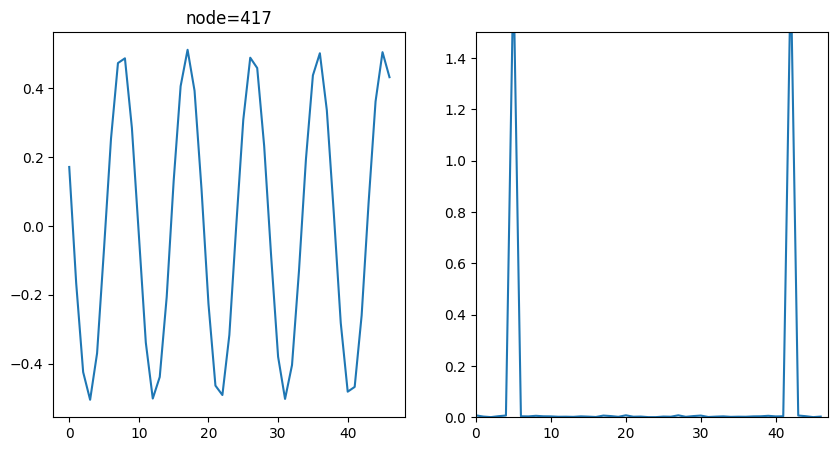

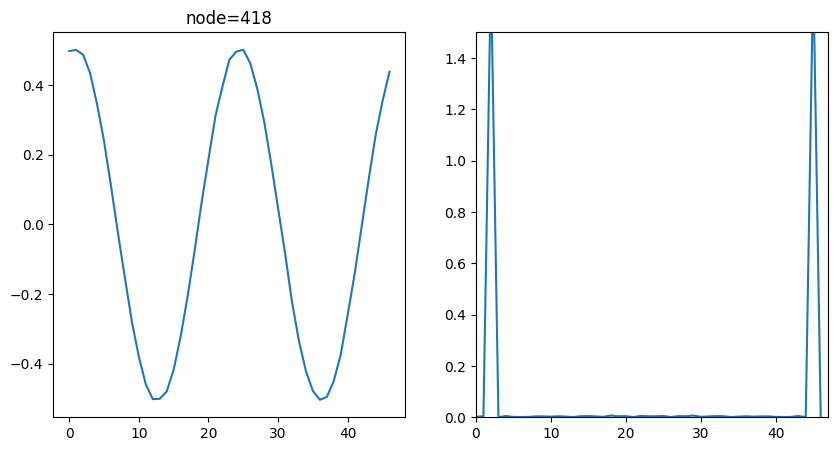

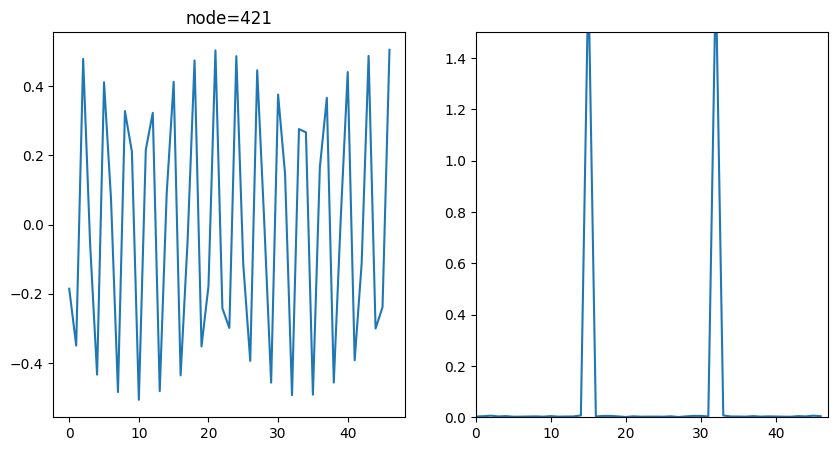

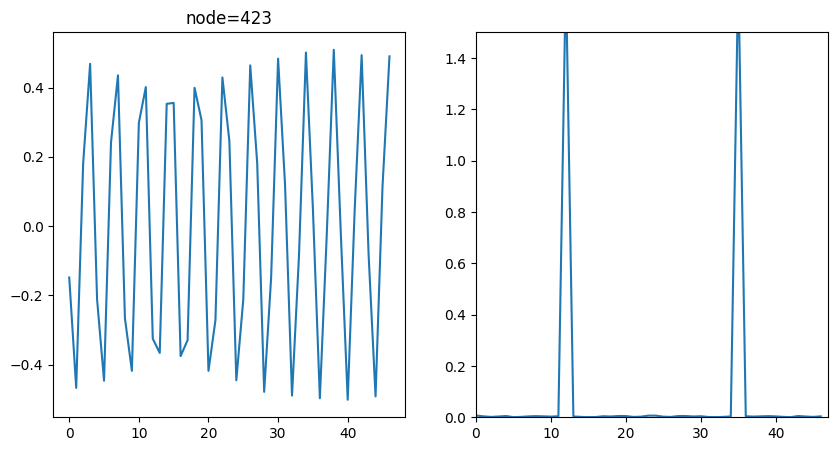

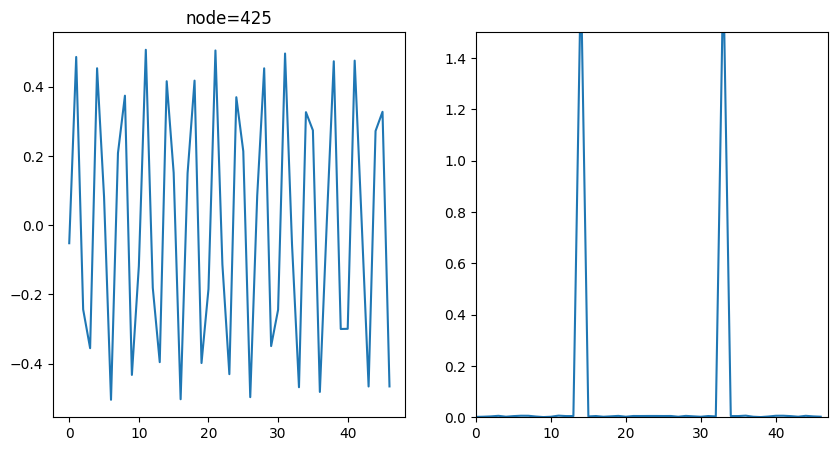

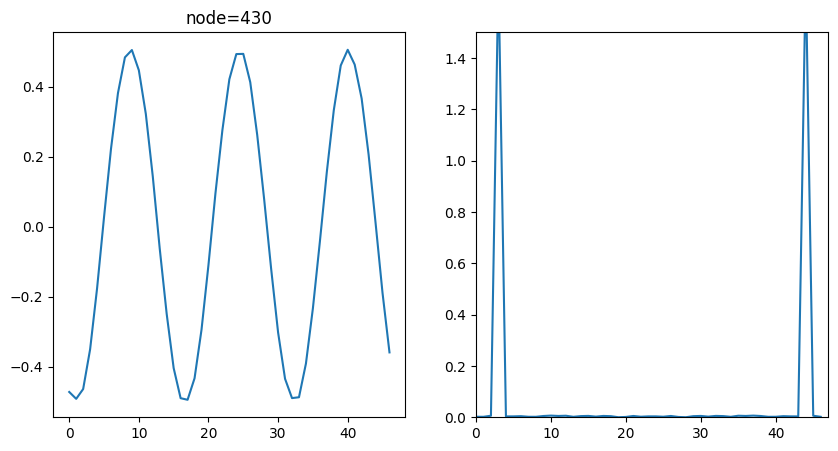

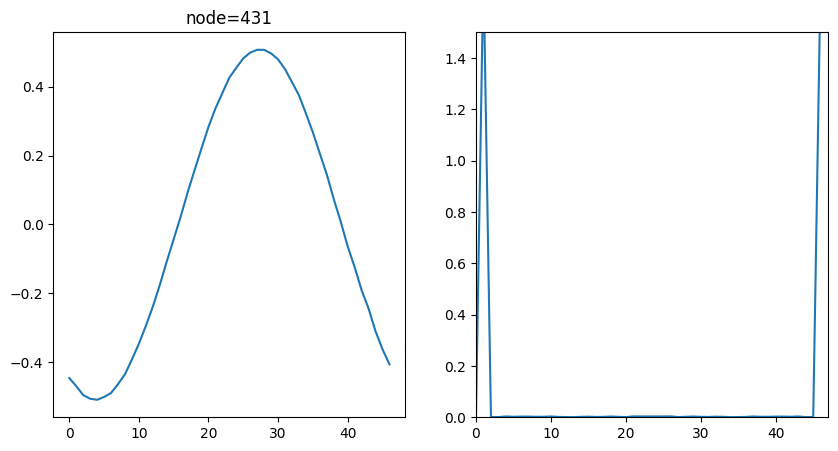

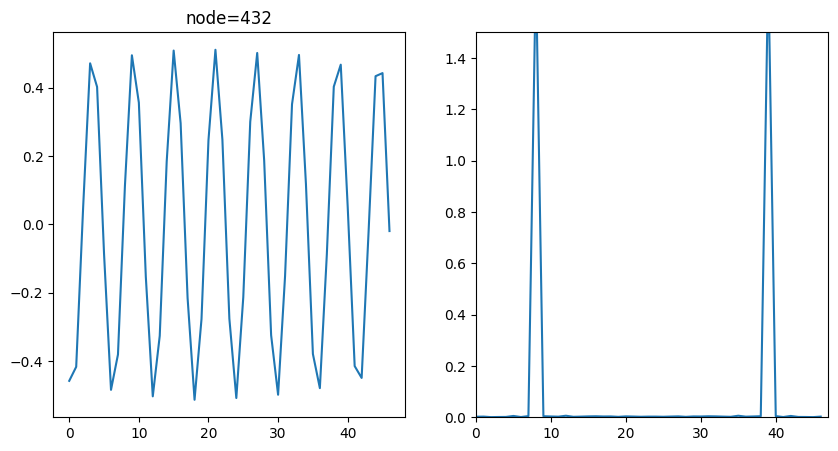

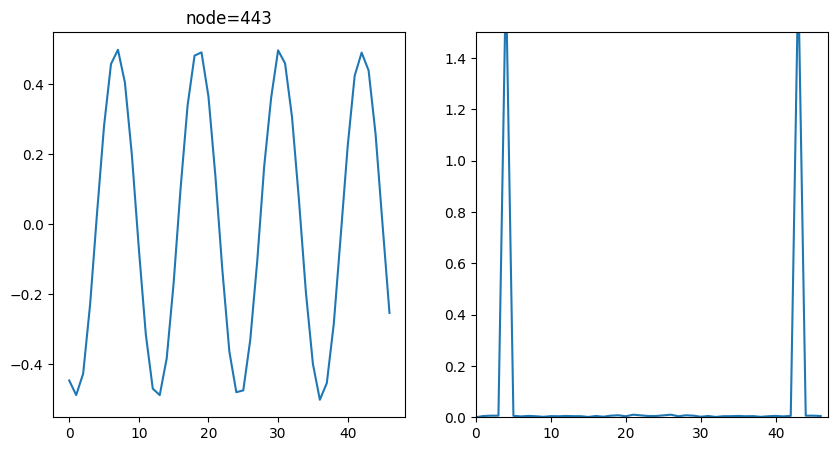

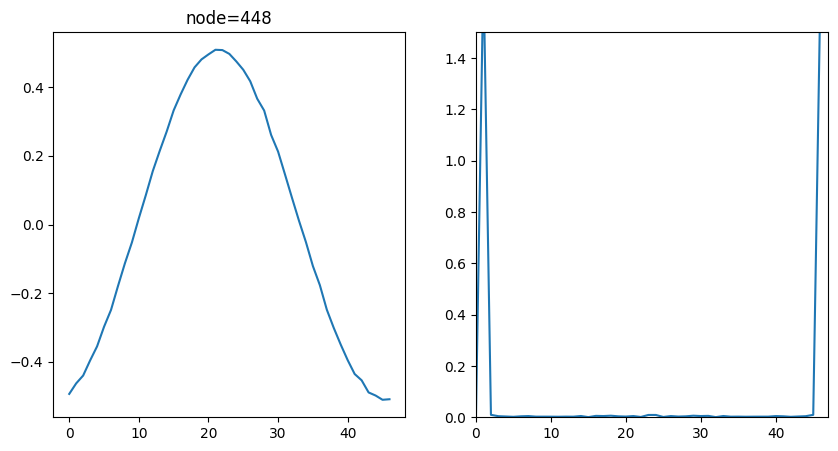

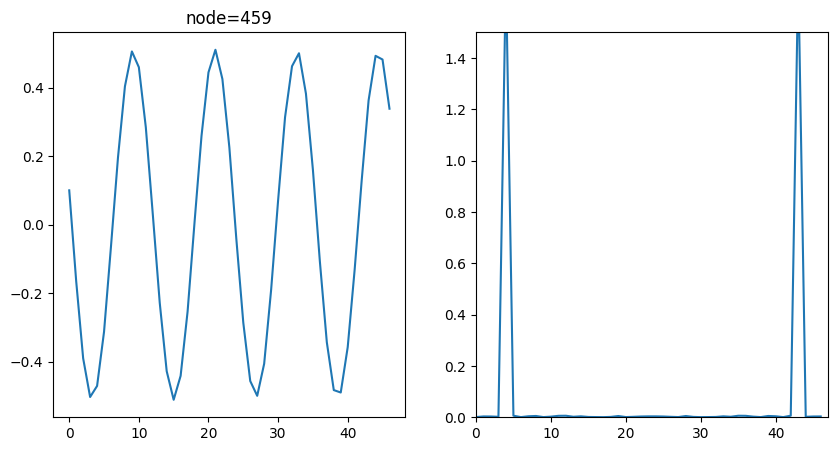

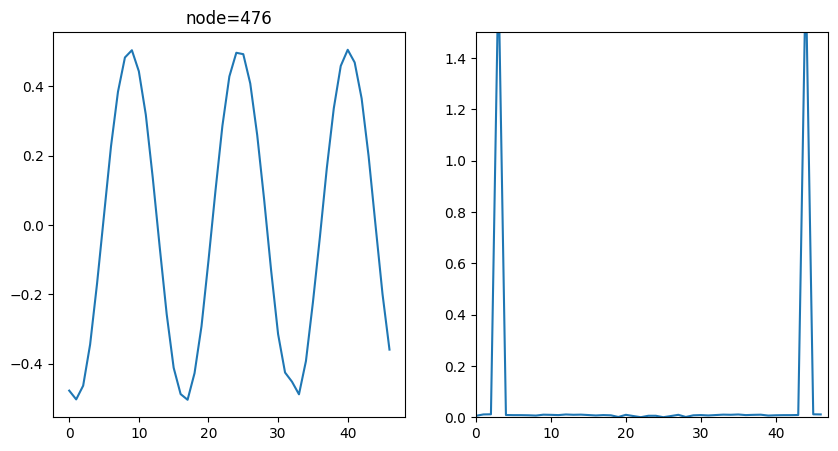

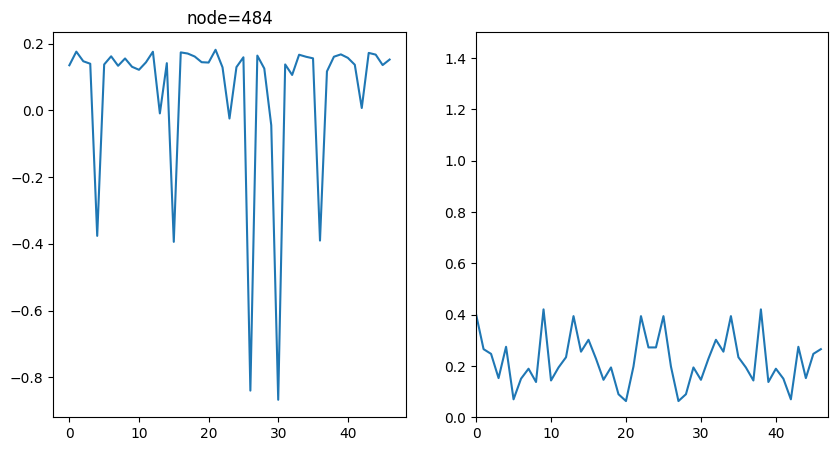

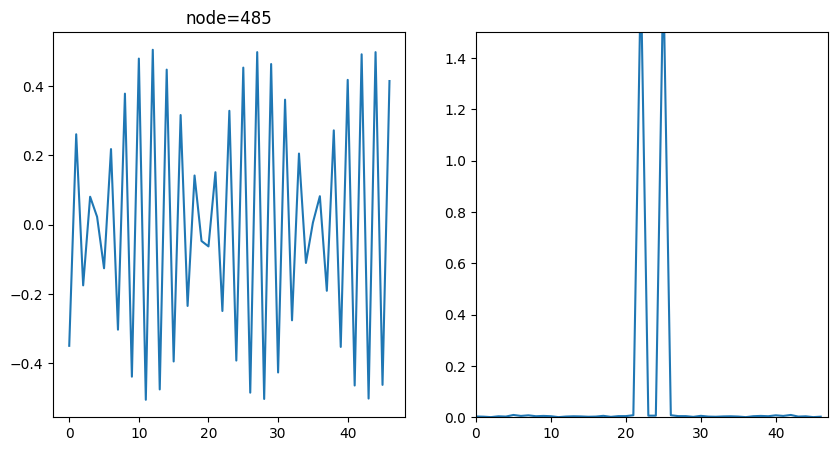

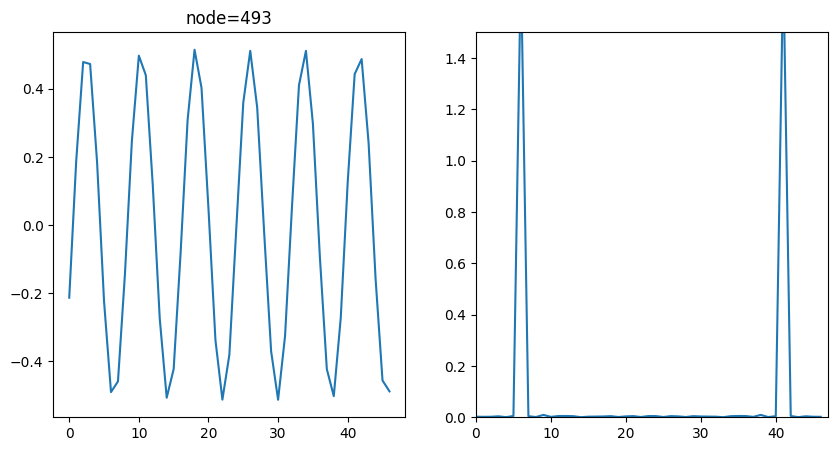

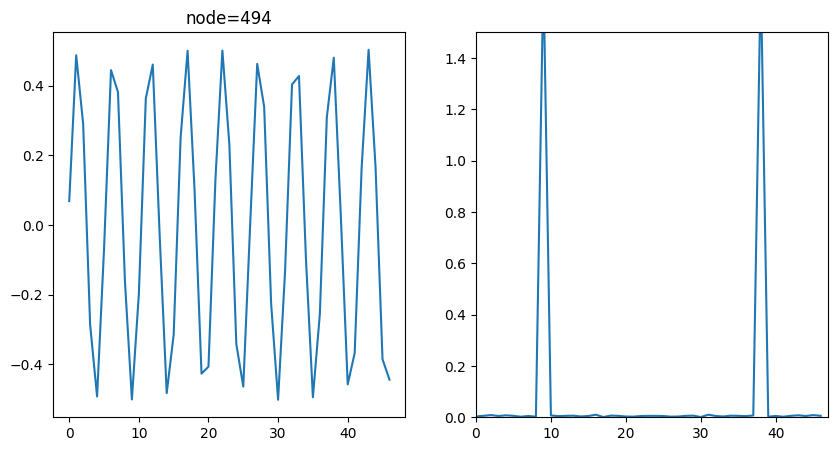

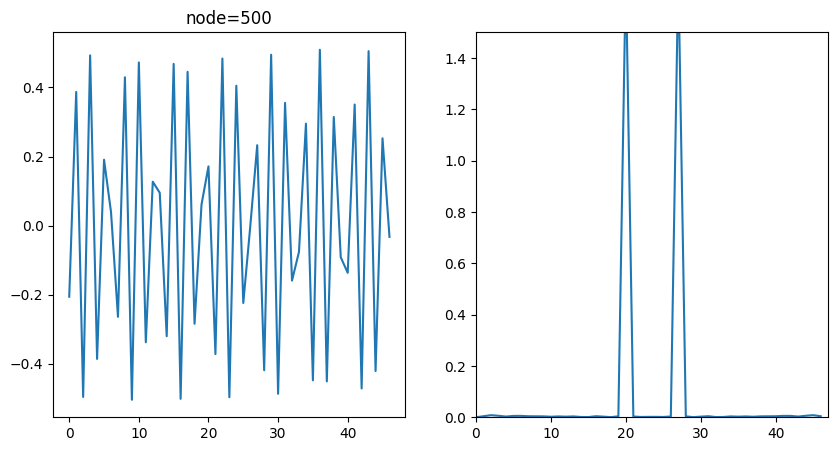

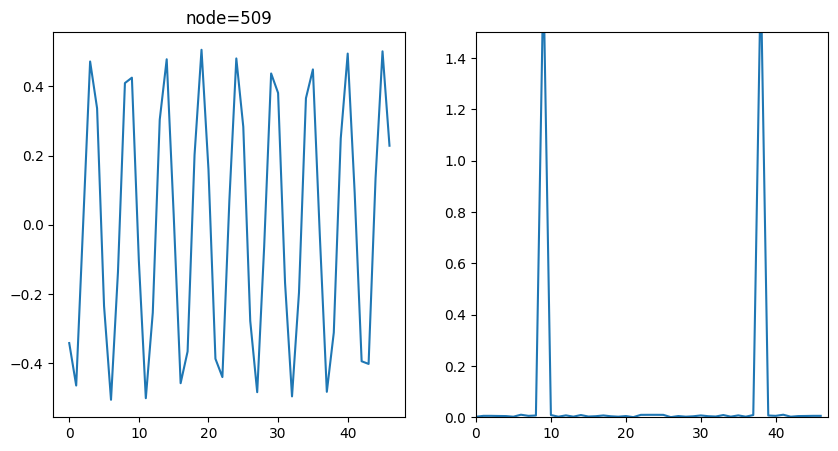

In [26]:
indices = (weights_norms["a"][-1,:] > 0.5).nonzero().squeeze()
print(indices.size())

for idx in indices:
    w = weights["a"][-1, idx, :]
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(w)
    plt.title(f"node={idx}")
    plt.subplot(1, 2, 2)
    # Fourier bases
    plt.plot((U.t() @ w.to(complex_type)).abs())
    plt.axis([0, d, 0, 1.5])

    plt.show()

In [305]:
weight_norms["a"][-1,40,:]

IndexError: too many indices for tensor of dimension 2

In [302]:
indices

tensor([5])

In [198]:
weights["a"].size()

torch.Size([298, 512, 71])

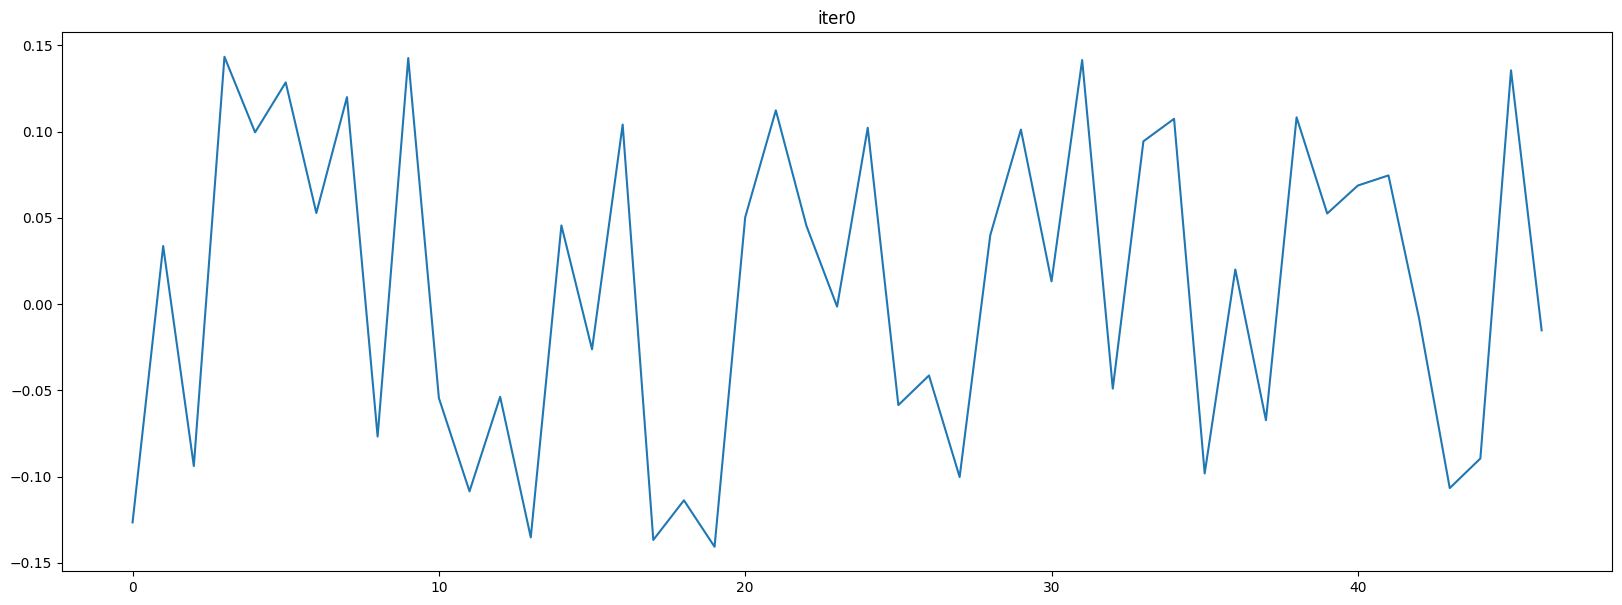

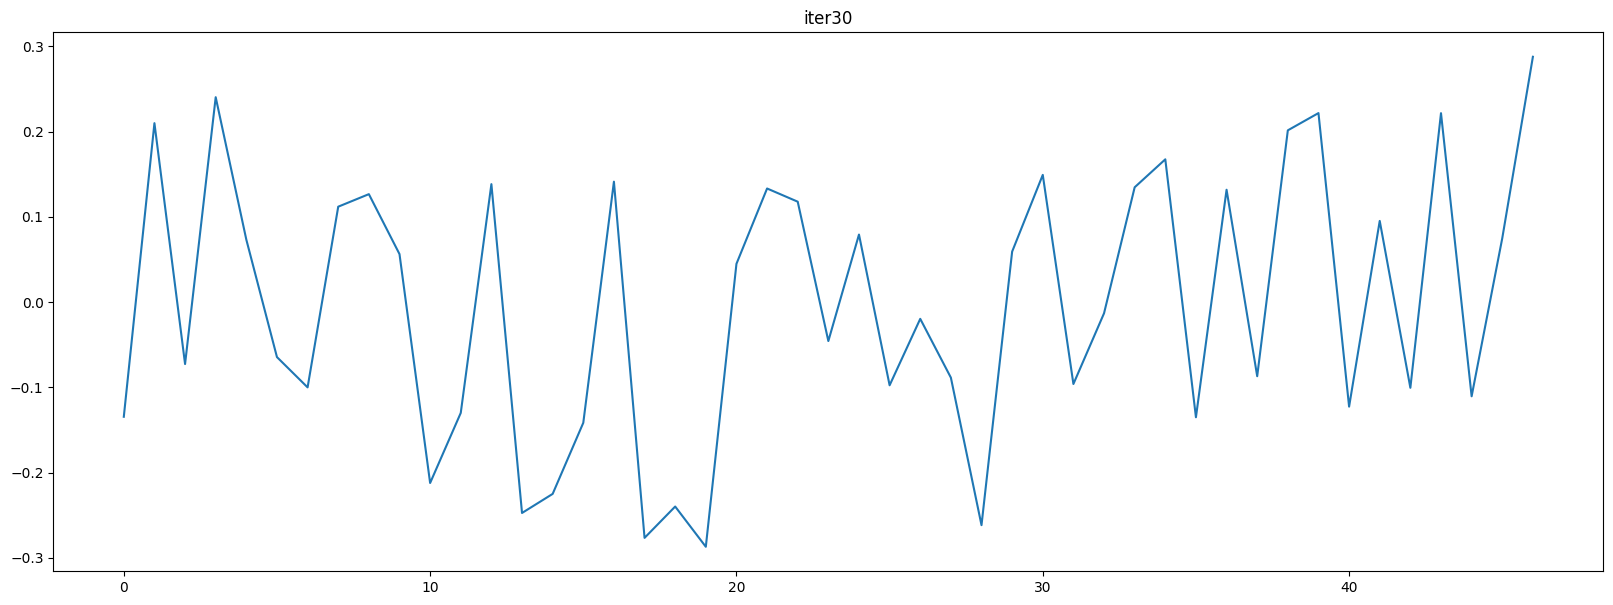

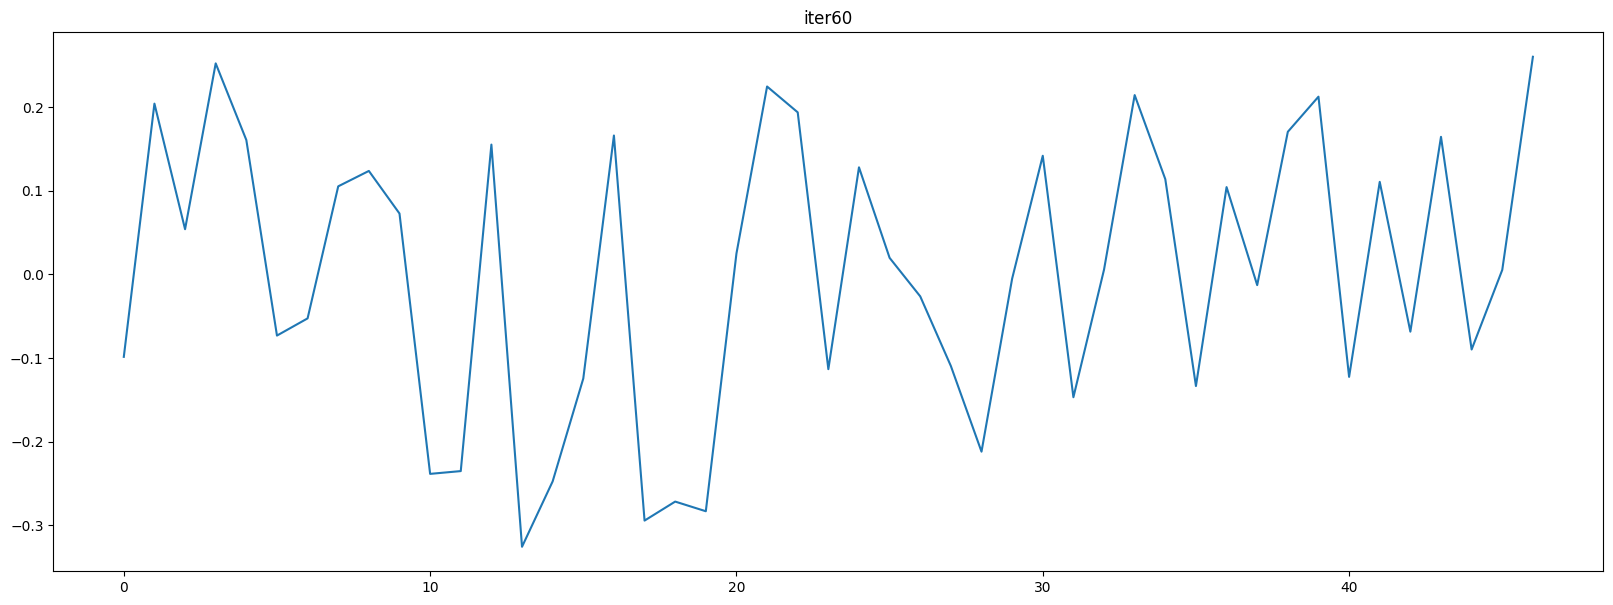

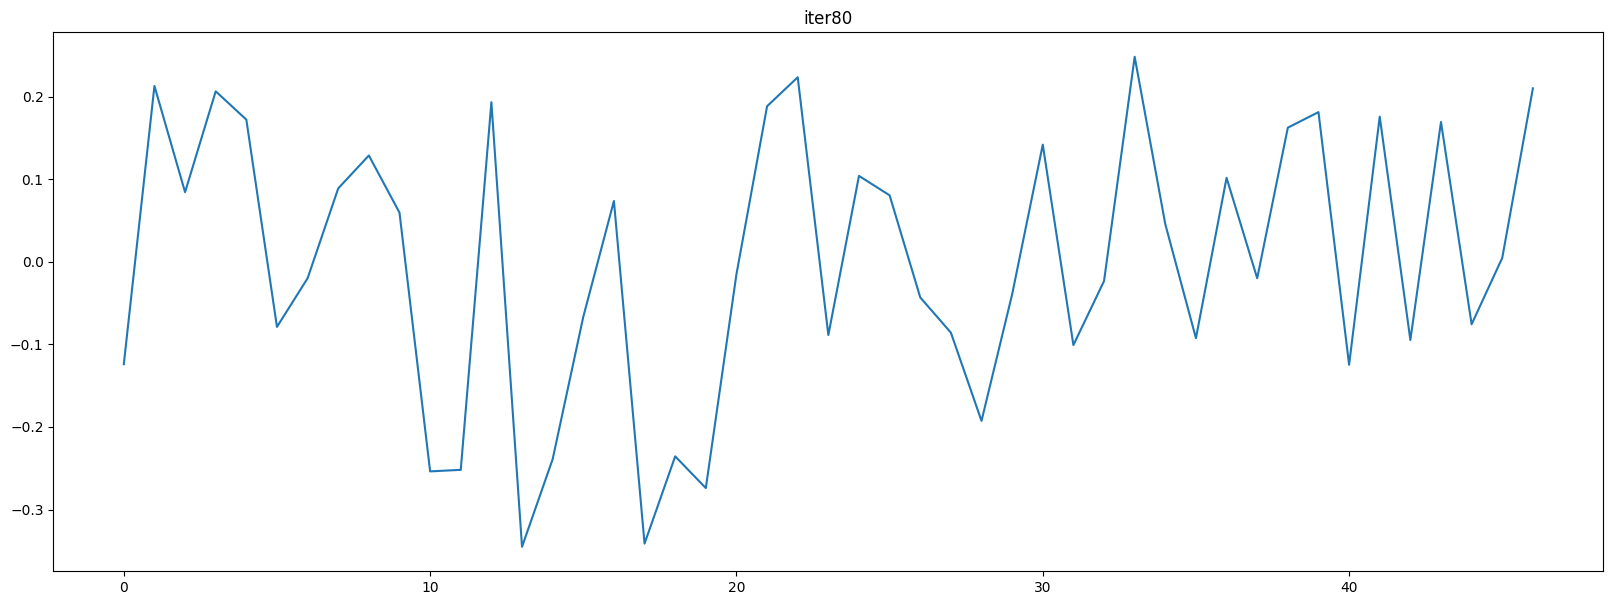

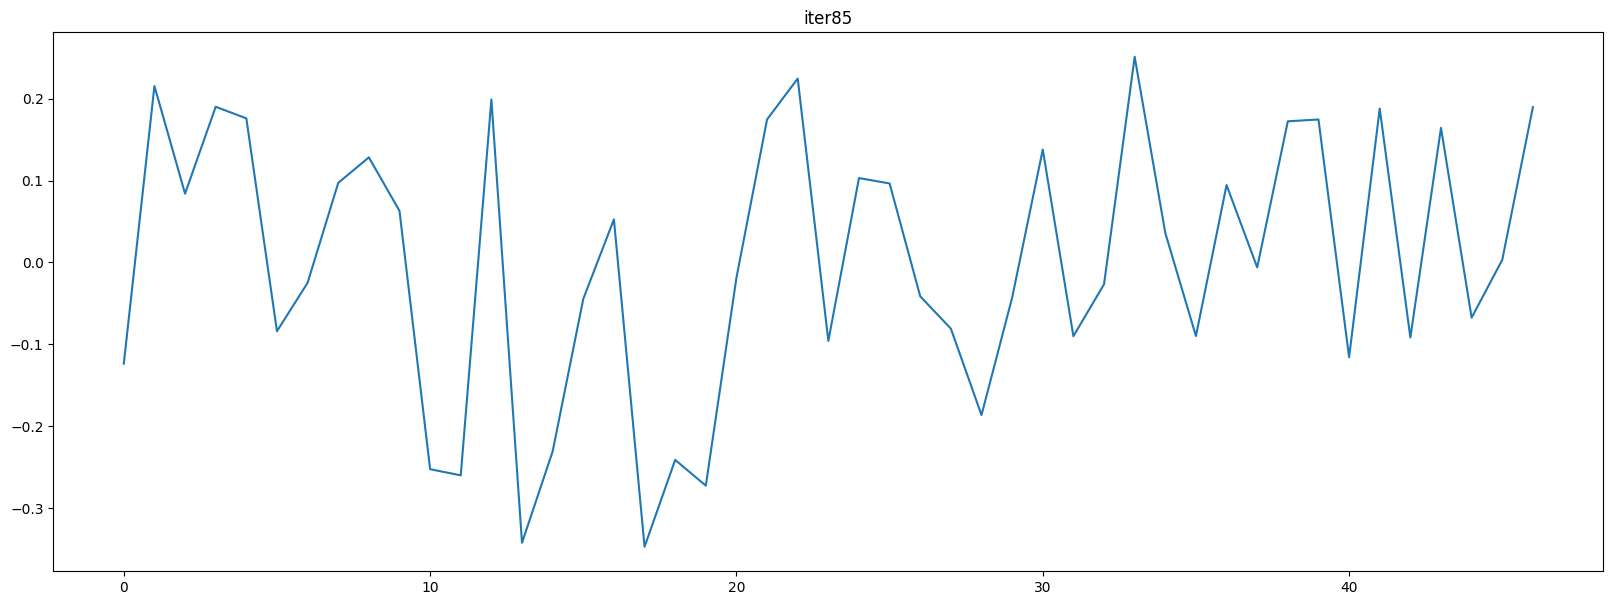

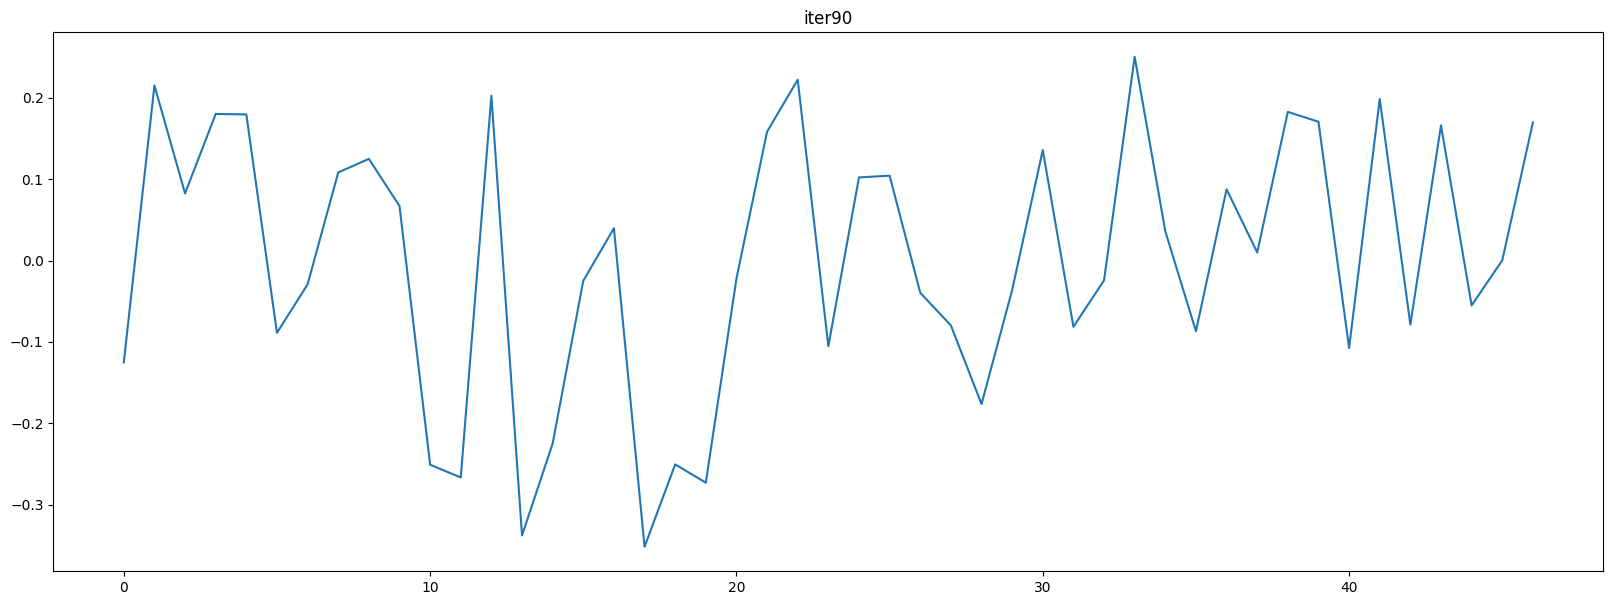

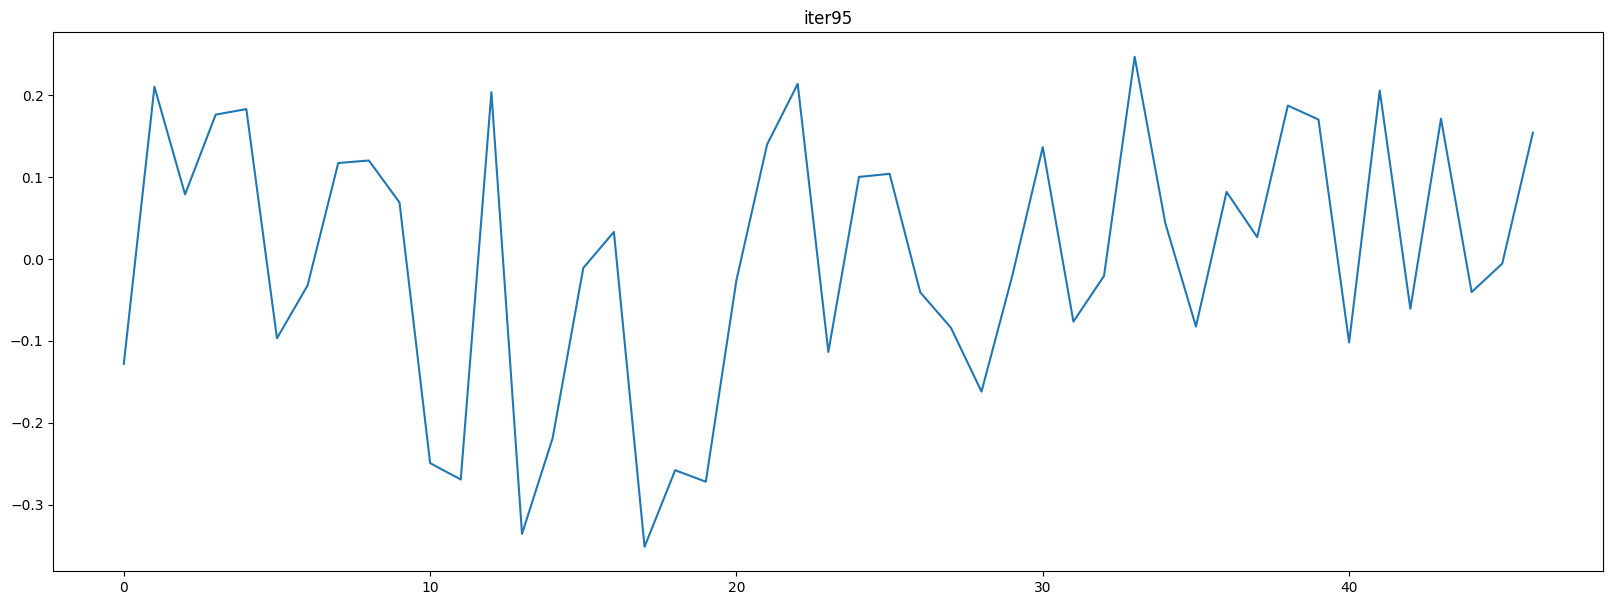

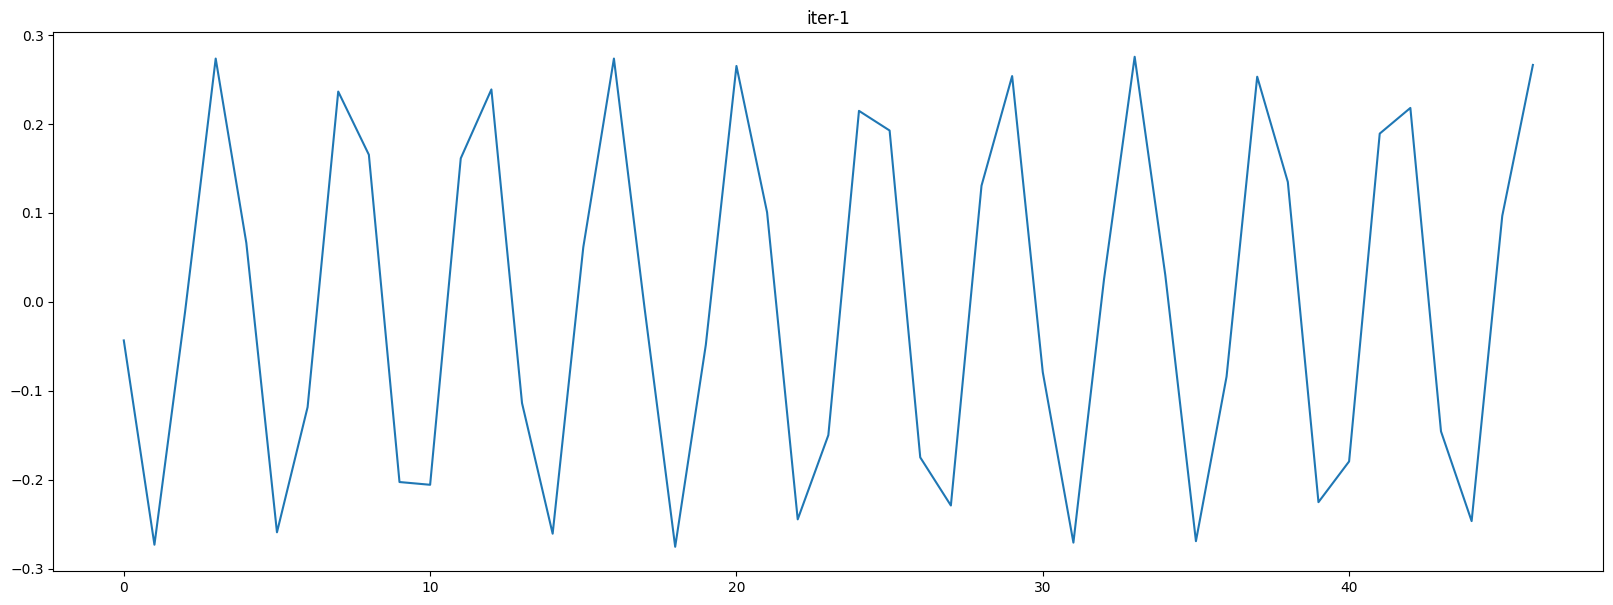

In [344]:
ts = [0, 30, 60, 80, 85, 90, 95, -1]

for t in ts:
    plt.figure(figsize=(20, 7))
    plt.plot(weights["a"][t, 253, :])
    plt.title(f"iter{t}")

In [149]:
weights["a"][100, 24, :].norm()

tensor(1.0529)

In [148]:
weights["a"][248, 24, :]

tensor([-5.2728e-41,  4.1530e-41, -2.0204e-41, -7.2507e-41, -1.2154e-40,
         4.8212e-41,  5.0050e-41,  1.2706e-40, -5.8728e-42,  5.4830e-41,
         1.9624e-41, -4.2773e-41,  1.3312e-40, -6.3783e-41, -8.7559e-41,
         1.2233e-40,  1.4310e-40, -8.9459e-41, -2.6178e-41, -5.6505e-41,
        -5.3108e-41,  1.1357e-40,  1.0487e-40,  1.3242e-40, -4.2267e-41,
         1.5705e-40, -5.2033e-41,  1.3423e-40,  2.9478e-41,  1.1322e-40,
         4.1923e-41, -1.8341e-40,  1.0844e-40, -3.7081e-41,  1.5594e-41,
         6.3086e-42, -1.7340e-40,  9.9991e-41, -1.0130e-40,  7.1686e-41,
        -6.5613e-41,  5.9365e-41, -6.2443e-41,  1.3273e-41, -1.0465e-41,
         3.6644e-42, -1.3789e-40,  4.0883e-41,  1.3277e-40, -1.3485e-40,
         1.5405e-40,  1.2245e-40, -4.6847e-41, -5.6416e-42, -1.1077e-40,
        -1.4857e-40,  4.9927e-41,  1.5790e-40,  1.2208e-40, -1.2717e-40,
        -7.8742e-41, -6.5861e-42,  1.8679e-41,  1.3300e-40,  2.7900e-42,
         1.1331e-40,  1.5131e-40, -4.7243e-41,  8.4

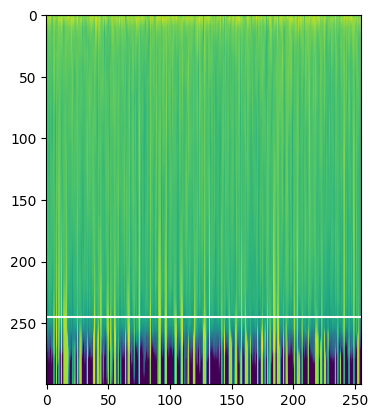

In [345]:
plt.imshow(weights["a"].norm(dim=2))
plt.axhline(y=grok_finished_idx, color='w')

(array([227.,   0.,  57.,  13.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,
         19.,  51.,   0.,   4.,   3.,   1.,   0.,   0.,   0.,   2.,   1.,
          1.,   2.,   6.,   5.,  41.,  38.,   2.,  36.]),
 array([0.        , 0.05298165, 0.1059633 , 0.15894493, 0.21192659,
        0.26490822, 0.31788987, 0.37087151, 0.42385319, 0.47683483,
        0.52981645, 0.58279812, 0.63577974, 0.68876141, 0.74174303,
        0.7947247 , 0.84770638, 0.90068799, 0.95366967, 1.00665128,
        1.0596329 , 1.11261463, 1.16559625, 1.21857786, 1.27155948,
        1.32454121, 1.37752283, 1.43050444, 1.48348606, 1.53646779,
        1.58944941]),
 <BarContainer object of 30 artists>)

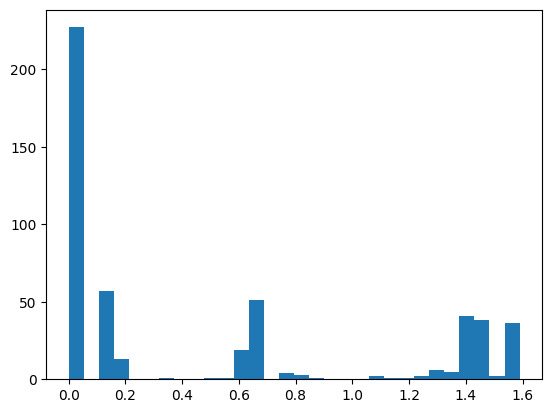

In [290]:
a_norms = weights["a"].norm(dim=2)
plt.hist(a_norms[-1,:], bins=30)

In [167]:
a_norms.size()

torch.Size([298, 512])

In [219]:
(a_norms[100, :] < 0.5).nonzero()

tensor([], size=(0, 1), dtype=torch.int64)

In [256]:
filenames

['/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00/model00000_train0.02_loss0.9908_test0.01_loss0.9915.pt',
 '/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00/model00100_train1.00_loss0.1221_test0.01_loss1.9035.pt',
 '/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00/model00200_train1.00_loss0.0325_test0.02_loss2.3617.pt',
 '/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00/model00300_train1.00_loss0.0168_test0.02_loss2.4966.pt',
 '/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00/model00400_train1.00_loss0.0112_test0.02_loss2.5347.pt',
 '/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00/model00500_train1.00_loss0.0086_test0.02_loss2.5396.pt',
 '/private/home/yuandong/luckmatters/ssl/real-dataset/cogo/outputs/2025-05-27/03-26-00/model00600_train1.00_loss0.0069_test0.02_loss2.53

In [257]:
len(filenames)

100

In [258]:
len(stats["train_loss"])

298